In [1]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import random

# Comparison on multiple datasets

In [2]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

In [4]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [5]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [6]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [7]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    #y_test_appended = np.concatenate([y_test,[1]])
    y_test_appended = clf.predict(X_test_appended)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [8]:
shap.initjs()

In [9]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [10]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [11]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
class CategoricalWrapper(BaseEstimator):
    def __init__(self, model, ohe_encoder = None, categorical_indicator=None, features = None, categories='auto'):
        if ohe_encoder is None:
            self.ohe_encoder = OneHotEncoder(categories=categories)
        else:
            self.ohe_encoder = ohe_encoder
            
        self.features = features
        self.categories=categories
        self.categorical_indicator=categorical_indicator
        self.ct = ColumnTransformer(  
            [("categorical", self.ohe_encoder, [f for f,c in zip(features,categorical_indicator) if c ] )],
        remainder='passthrough')
        
        self.model = model
    
    def fit(self, X,y):
        X_tr = self.ct.fit_transform(X)
        self.model.fit(X_tr,y)
        return self
    def predict(self,X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict(self.ct.transform(X))
    
    def predict_proba(self, X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict_proba(self.ct.transform(X))

In [12]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            if len((set(v1)|set(v2))) == 0:
                jackard = 0
            else:
                jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

In [13]:
def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f' and {i}{op}'.join(v))
    print(' and '.join(query))
    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

In [14]:
# def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
#     #TODO: calculate stats separtelly fro each class
#     results_mean =[] 
#     results_std =[] 
#     for true_class in rules_and_instances['true_class'].unique():
#         rules = rules_and_instances[rules_and_instances['true_class']==true_class]
#         instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
#         jackart = np.zeros((rules.shape[0],rules.shape[0]))
#         for i in range(rules.shape[0]):
#             for ii in range(rules.shape[0]):
#                 jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
#         stab = jackart/(instance_similarity+1)
#         results_mean.append(np.mean(stab))
#         results_std.append(np.std(stab))
#     return (np.mean(results_mean), np.mean(results_std)) #large stability, low variance is desired

def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            if len(set(rule_1.keys())|set(rule_2.keys())) == 0:
                feature_jackart[i,ii] = 0
            else:
                feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired



In [15]:
def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Main comparison loop

## Benchmark, model agnostic

In [16]:
def predict_lux(model,X,y=None):
        if isinstance(X, pd.DataFrame):
            pass
        elif isinstance(X,np.ndarray):
            X = pd.DataFrame(X,columns=model.attributes_names)
        else:
            raise ValueError("Only 2D arrrays are allowed as an input")
            
        if y is None:
            y = pd.Series(np.arange(X.shape[0]),name='target_unused',index=X.index) # This is not used, but Data resered last 
                
        X=pd.concat((X,y),axis=1)
        XData = Data.parse_dataframe(X,'lux')
        return [int(f.get_name()) for f in model.predict(XData.get_instances())]

In [17]:
def generate_lore_dataset(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

data_house_16H
Accuracy  model: 0.8787069988137604 for data_house_16H
Train size: 10116
----------- Model certainty for instance: 0.9518029393894942 ---------------
Neighbourhood size: 250
Average distace of neighbourhood: 1.8381460770445741.
Neighbourhood size: 250
Average distace of neighbourhood: 1.5838138883802364.
Done 1.0082352941176471 upsampling
OS Botj OK
Train sample size: 2462 (0.24337682878608147)


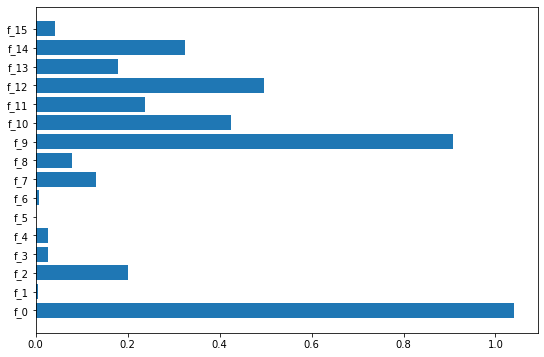

Fidelity  dectree: 0.9678899082568808
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.24337682878608147 samples from train set wiuth class balance: 0.5
--- 299.447065114975 seconds ---
IF f_0 <-0.10939577221870422 AND f_14 >=-0.5869548618793488 AND f_9 <0.1189308911561966 THEN class = 0 # 1.0



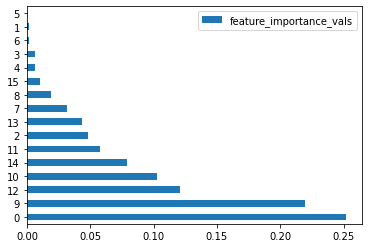

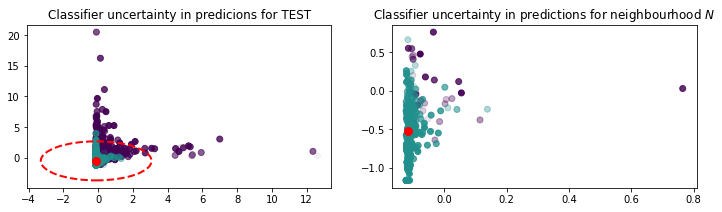

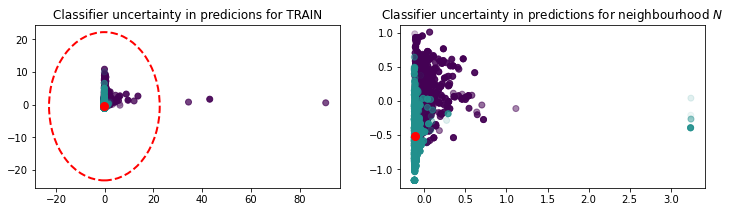

Fidelity  with shap: 0.9408983451536644
f_0<-0.10939577221870422 and f_14>=-0.5869548618793488 and f_9<0.1189308911561966
f_0<-0.10939577221870422 and f_14>=-0.5869548618793488 and f_9<0.1189308911561966
SHAPGAIN LUX:0.18331924502342992
Fidelity  EXPLAN: 0.8962025316455696
LORE expl e = {'f_9': ['<0.44292719662189484'], 'f_11': ['<-0.3836337774991989'], 'f_0': ['<-0.11267511919140816'], 'f_13': ['>=-0.5143358707427979']}
f_9<0.44292719662189484 and f_11<-0.3836337774991989 and f_0<-0.11267511919140816 and f_13>=-0.5143358707427979
f_9<0.44292719662189484 and f_11<-0.3836337774991989 and f_0<-0.11267511919140816 and f_13>=-0.5143358707427979
SHAPGAIN explan:0.14307988216981835
Fidelity  LORE: 0.9170731707317074
LORE expl e = {'f_13': ['>=-1.003861665725708'], 'f_0': ['<-0.10149187967181206'], 'f_9': ['<-0.16078786551952362']}
Ats lore: ['f_13', 'f_0', 'f_9']
f_13>=-1.003861665725708 and f_0<-0.10149187967181206 and f_9<-0.16078786551952362
f_13>=-1.003861665725708 and f_0<-0.10149187967

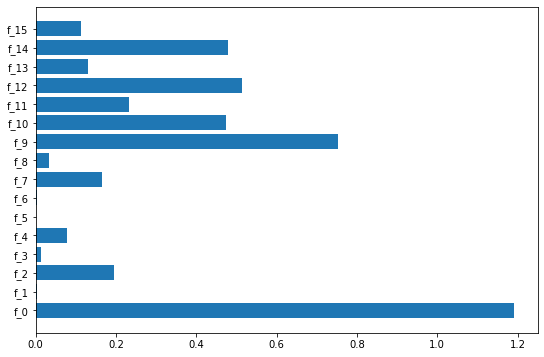

Fidelity  dectree: 0.9208211143695014
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.26176354290233295 samples from train set wiuth class balance: 0.4984894259818731
--- 335.29704451560974 seconds ---
IF f_9 <-0.020113328471779823 AND f_12 >=0.18571480363607407 AND f_0 <-0.11121831834316254 AND f_13 >=-1.1294330954551697 THEN class = 0 # 1.0



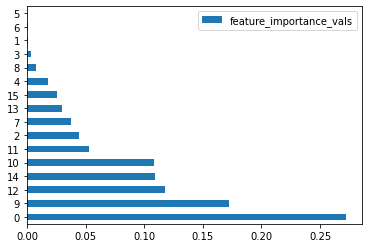

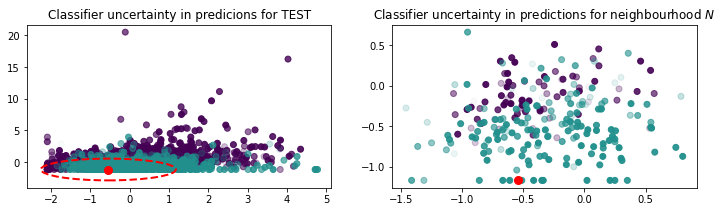

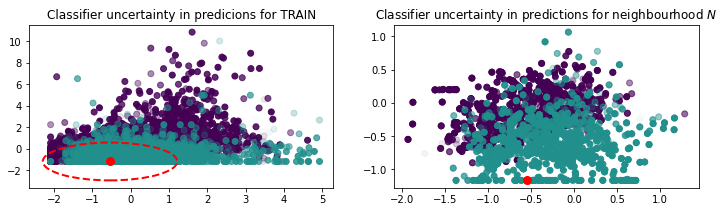

Fidelity  with shap: 0.9176470588235294
f_9<-0.020113328471779823 and f_12>=0.18571480363607407 and f_0<-0.11121831834316254 and f_13>=-1.1294330954551697
f_9<-0.020113328471779823 and f_12>=0.18571480363607407 and f_0<-0.11121831834316254 and f_13>=-1.1294330954551697
SHAPGAIN LUX:0.14773725631616982
Fidelity  EXPLAN: 0.8421052631578947
LORE expl e = {'f_9': ['<-0.06554929539561272'], 'f_2': ['<-0.37565214931964874'], 'f_0': ['<-0.09800177067518234'], 'f_13': ['>=-0.9651327729225159']}
f_9<-0.06554929539561272 and f_2<-0.37565214931964874 and f_0<-0.09800177067518234 and f_13>=-0.9651327729225159
f_9<-0.06554929539561272 and f_2<-0.37565214931964874 and f_0<-0.09800177067518234 and f_13>=-0.9651327729225159
SHAPGAIN explan:0.1295042610556438
Fidelity  LORE: 0.8761329305135951
LORE expl e = {'f_13': ['>=-1.7897530794143677'], 'f_0': ['<-0.10338261723518372'], 'f_9': ['<0.11926870048046112']}
Ats lore: ['f_13', 'f_0', 'f_9']
f_13>=-1.7897530794143677 and f_0<-0.10338261723518372 and f_9

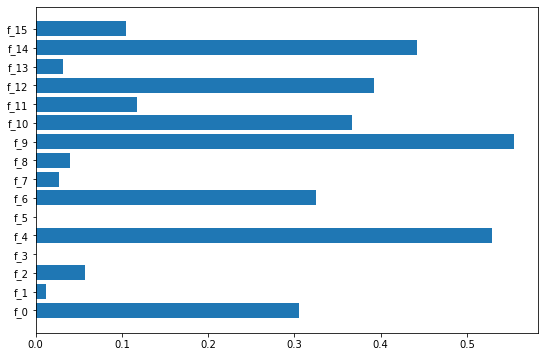

Fidelity  dectree: 0.9896049896049897
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.4375247133254251 samples from train set wiuth class balance: 0.5135562584726615
--- 523.7267582416534 seconds ---
IF f_9 >=0.7213994264602661 AND f_12 <0.31022413074970245 AND f_0 >=-0.11180800944566727 AND f_14 <0.07454268261790276 THEN class = 1 # 1.0



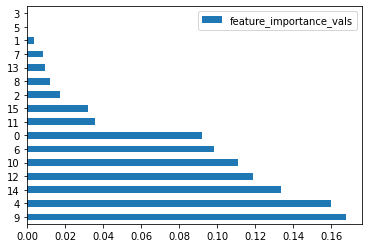

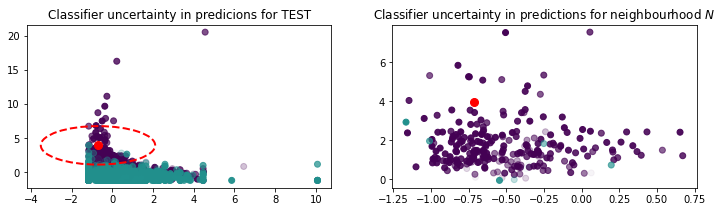

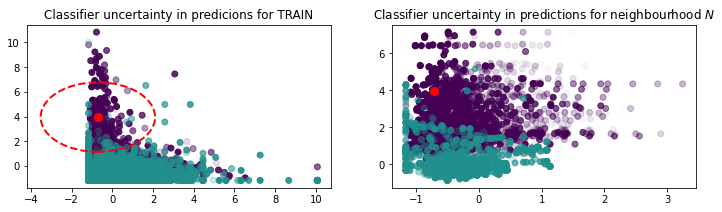

Fidelity  with shap: 0.9725158562367866
f_9>=0.7213994264602661 and f_12<0.31022413074970245 and f_0>=-0.11180800944566727 and f_14<0.07454268261790276
f_9>=0.7213994264602661 and f_12<0.31022413074970245 and f_0>=-0.11180800944566727 and f_14<0.07454268261790276
SHAPGAIN LUX:0.12804907201180457
Fidelity  EXPLAN: 0.8929384965831436
LORE expl e = {'f_9': ['>=-0.15653853863477707'], 'f_5': ['<-2.169959306716919']}
f_9>=-0.15653853863477707 and f_5<-2.169959306716919
f_9>=-0.15653853863477707 and f_5<-2.169959306716919
SHAPGAIN explan:0.08381055000501002
Fidelity  LORE: 0.9917695473251029
LORE expl e = {'f_4': ['<0.43947678804397583'], 'f_0': ['>=-0.11134850233793259'], 'f_9': ['>=-0.23405341804027557']}
Ats lore: ['f_4', 'f_0', 'f_9']
f_4<0.43947678804397583 and f_0>=-0.11134850233793259 and f_9>=-0.23405341804027557
f_4<0.43947678804397583 and f_0>=-0.11134850233793259 and f_9>=-0.23405341804027557
SHAPGAIN lore:0.13994031503808144
SHAPGAIN anchor:0.13994031503808144
Anchor explanation:

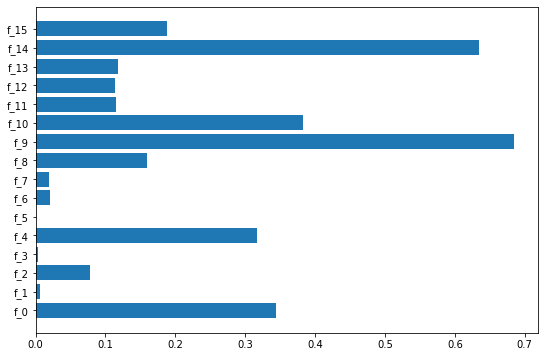

Fidelity  dectree: 0.9918032786885246
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.4331751680506129 samples from train set wiuth class balance: 0.5175718849840255
--- 578.3626639842987 seconds ---
IF f_8 <1.2450637221336365 AND f_9 >=0.4135598987340927 AND f_12 <0.31515298783779144 AND f_12 >=0.30400092899799347 AND f_0 >=-0.11119972169399261 AND f_14 <-0.3027348965406418 THEN class = 1 # 1.0



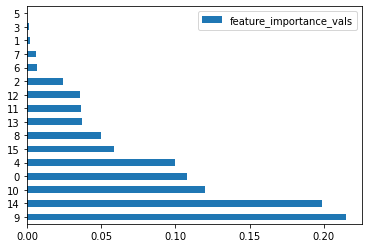

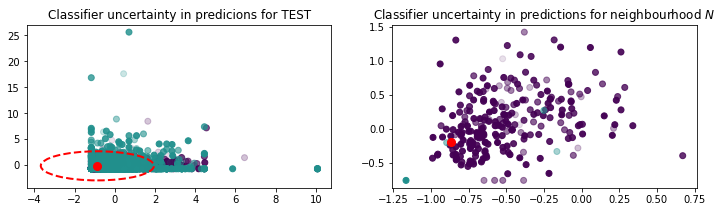

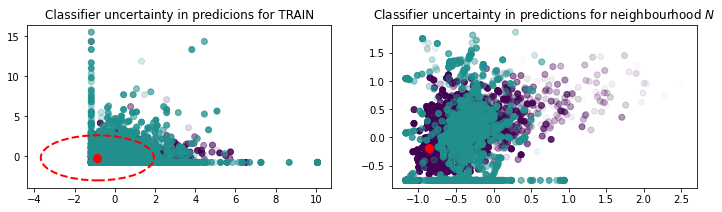

Fidelity  with shap: 0.9771309771309771
f_8<1.2450637221336365 and f_9>=0.4135598987340927 and f_12<0.31515298783779144 and f_12>=0.30400092899799347 and f_0>=-0.11119972169399261 and f_14<-0.3027348965406418
f_8<1.2450637221336365 and f_9>=0.4135598987340927 and f_12<0.31515298783779144 and f_12>=0.30400092899799347 and f_0>=-0.11119972169399261 and f_14<-0.3027348965406418
SHAPGAIN LUX:0.12153774101700246
Fidelity  EXPLAN: 0.9773195876288661
LORE expl e = {'f_9': ['>=-0.3526463955640793'], 'f_12': ['<0.3528888374567032'], 'f_15': ['<-0.11336564272642136'], 'f_0': ['>=-0.11255113035440445']}
f_9>=-0.3526463955640793 and f_12<0.3528888374567032 and f_15<-0.11336564272642136 and f_0>=-0.11255113035440445
f_9>=-0.3526463955640793 and f_12<0.3528888374567032 and f_15<-0.11336564272642136 and f_0>=-0.11255113035440445
SHAPGAIN explan:0.1043729668093021
Fidelity  LORE: 0.991869918699187
LORE expl e = {'f_0': ['>=-0.1122845709323883'], 'f_9': ['>=-0.32273706793785095']}
Ats lore: ['f_0', 'f_

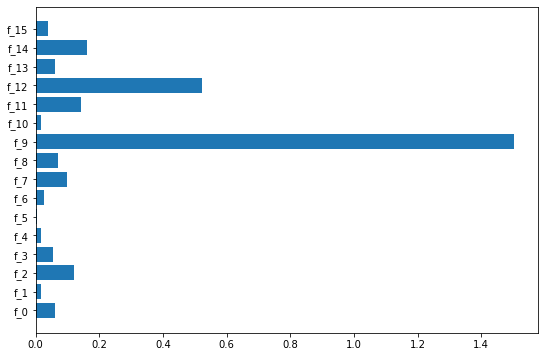

Fidelity  dectree: 0.9567307692307692
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2368525108738632 samples from train set wiuth class balance: 0.49958263772954925
--- 300.23485112190247 seconds ---
IF f_9 <-0.17133305221796036 AND f_0 <-0.10778991132974625 AND f_10 >=-0.5290098190307617 AND f_14 <0.18719667941331863 THEN class = 0 # 1.0



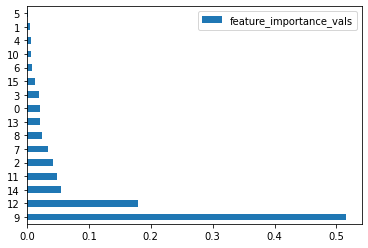

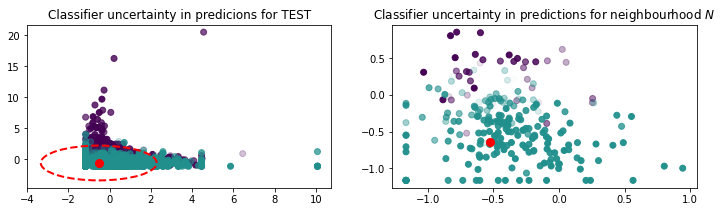

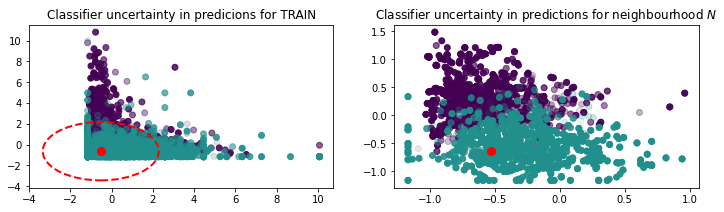

Fidelity  with shap: 0.9556650246305418
f_9<-0.17133305221796036 and f_0<-0.10778991132974625 and f_10>=-0.5290098190307617 and f_14<0.18719667941331863
f_9<-0.17133305221796036 and f_0<-0.10778991132974625 and f_10>=-0.5290098190307617 and f_14<0.18719667941331863
SHAPGAIN LUX:0.14791293516447285
Fidelity  EXPLAN: 0.9323671497584541
LORE expl e = {'f_7': ['<0.6996760368347168'], 'f_9': ['<-0.3031149059534073'], 'f_0': ['<-0.1046348437666893', '>=-0.11137329787015915'], 'f_13': ['>=-0.7409412264823914']}
f_7<0.6996760368347168 and f_9<-0.3031149059534073 and f_0<-0.1046348437666893 and f_0>=-0.11137329787015915 and f_13>=-0.7409412264823914
f_7<0.6996760368347168 and f_9<-0.3031149059534073 and f_0<-0.1046348437666893 and f_0>=-0.11137329787015915 and f_13>=-0.7409412264823914
SHAPGAIN explan:0.14783901986129974
Fidelity  LORE: 0.8911917098445595
LORE expl e = {'f_4': ['>=-1.362838625907898'], 'f_9': ['<-0.34375646710395813'], 'f_3': ['<3.6067211627960205'], 'f_13': ['>=-1.106344521045

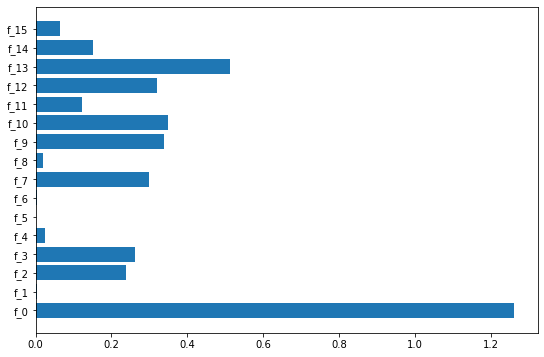

Fidelity  dectree: 0.8794326241134751
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.22874654013444048 samples from train set wiuth class balance: 0.5
--- 259.14129996299744 seconds ---
IF f_4 >=-0.9630683958530426 AND f_0 <-0.12103154510259628 AND f_13 <-1.1111720204353333 AND f_13 >=-1.6773017048835754 THEN class = 0 # 1.0



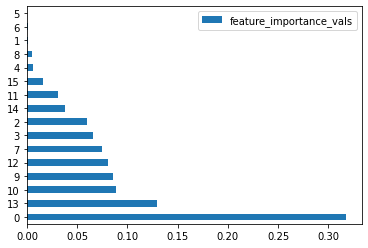

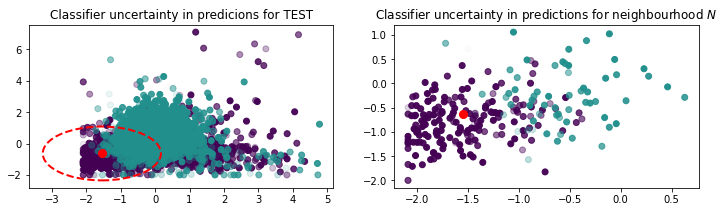

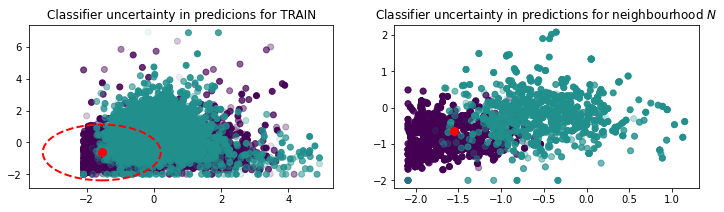

Fidelity  with shap: 0.906474820143885
f_4>=-0.9630683958530426 and f_0<-0.12103154510259628 and f_13<-1.1111720204353333 and f_13>=-1.6773017048835754
f_4>=-0.9630683958530426 and f_0<-0.12103154510259628 and f_13<-1.1111720204353333 and f_13>=-1.6773017048835754
SHAPGAIN LUX:0.1488764242223695
Fidelity  EXPLAN: 0.7516778523489932
LORE expl e = {'f_4': ['<0.01449994184076786'], 'f_9': ['<-0.28576506674289703'], 'f_0': ['<-0.11710129678249359'], 'f_13': ['<-0.056537169963121414'], 'f_10': ['>=-0.5714116990566254']}
f_4<0.01449994184076786 and f_9<-0.28576506674289703 and f_0<-0.11710129678249359 and f_13<-0.056537169963121414 and f_10>=-0.5714116990566254
f_4<0.01449994184076786 and f_9<-0.28576506674289703 and f_0<-0.11710129678249359 and f_13<-0.056537169963121414 and f_10>=-0.5714116990566254
SHAPGAIN explan:0.12404909138231582
Fidelity  LORE: 0.5686274509803921
LORE expl e = {'f_2': ['<-0.4060871750116348'], 'f_12': ['>=0.336874857544899'], 'f_0': ['<-0.12243254855275154']}
Ats lor

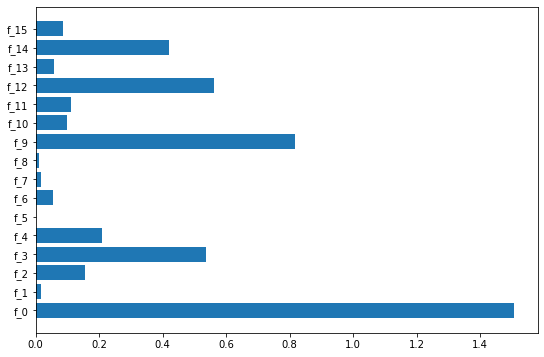

Fidelity  dectree: 0.974477958236659
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2856860419137999 samples from train set wiuth class balance: 0.49930795847750864
--- 346.1530439853668 seconds ---
IF f_0 <-0.10782119259238243 AND f_9 <-0.25851206481456757 THEN class = 0 # 0.9964994165694282



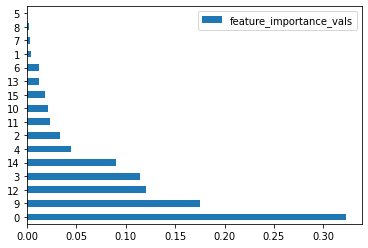

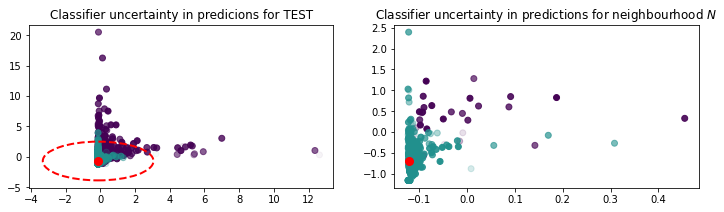

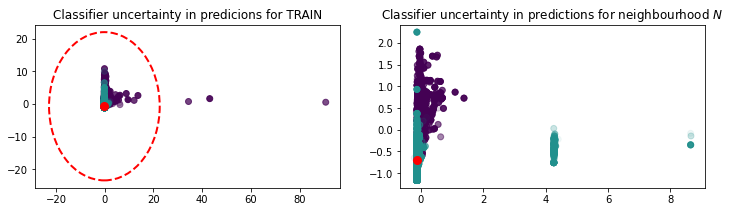

Fidelity  with shap: 0.9672897196261683
f_0<-0.10782119259238243 and f_9<-0.25851206481456757
f_0<-0.10782119259238243 and f_9<-0.25851206481456757
SHAPGAIN LUX:0.2489616263695227
Fidelity  EXPLAN: 0.947867298578199
LORE expl e = {'f_4': ['>=0.6843822598457336'], 'f_9': ['<-0.424625039100647', '>=-1.1641666889190674'], 'f_13': ['>=-1.1693180203437805'], 'f_10': ['>=-0.5856814980506897'], 'f_14': ['<-0.6045975685119629']}
f_4>=0.6843822598457336 and f_9<-0.424625039100647 and f_9>=-1.1641666889190674 and f_13>=-1.1693180203437805 and f_10>=-0.5856814980506897 and f_14<-0.6045975685119629
f_4>=0.6843822598457336 and f_9<-0.424625039100647 and f_9>=-1.1641666889190674 and f_13>=-1.1693180203437805 and f_10>=-0.5856814980506897 and f_14<-0.6045975685119629
SHAPGAIN explan:0.06624389492488779
Fidelity  LORE: 0.9383886255924171
LORE expl e = {'f_4': ['>=0.11714767664670944'], 'f_9': ['<0.5002123117446899'], 'f_0': ['<-0.11478902027010918'], 'f_13': ['>=-1.5848820805549622']}
Ats lore: ['f_4'

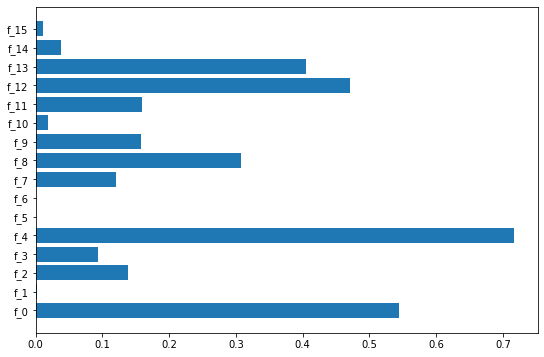

Fidelity  dectree: 0.936986301369863
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2712534598655595 samples from train set wiuth class balance: 0.5043731778425656
--- 334.13047790527344 seconds ---
IF f_4 <-0.8089056611061096 AND f_9 <0.08283912762999535 AND f_9 >=-0.3948560506105423 AND f_12 >=-0.047772305086255074 AND f_0 <-0.11208000034093857 AND f_13 >=-0.7738834023475647 THEN class = 0 # 1.0



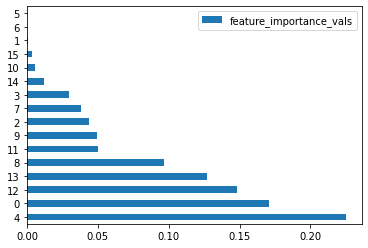

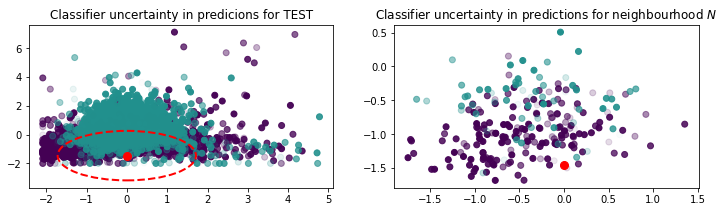

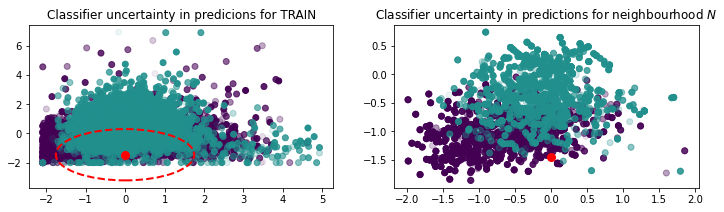

Fidelity  with shap: 0.935933147632312
f_4<-0.8089056611061096 and f_9<0.08283912762999535 and f_9>=-0.3948560506105423 and f_12>=-0.047772305086255074 and f_0<-0.11208000034093857 and f_13>=-0.7738834023475647
f_4<-0.8089056611061096 and f_9<0.08283912762999535 and f_9>=-0.3948560506105423 and f_12>=-0.047772305086255074 and f_0<-0.11208000034093857 and f_13>=-0.7738834023475647
SHAPGAIN LUX:0.1440481808980469
Fidelity  EXPLAN: 0.8707865168539327
LORE expl e = {'f_1': ['>=0.07952100038528442'], 'f_8': ['>=2.1694952249526978'], 'f_15': ['<-0.5789604783058167'], 'f_0': ['<-0.11044342815876007'], 'f_13': ['>=-0.287074476480484']}
f_1>=0.07952100038528442 and f_8>=2.1694952249526978 and f_15<-0.5789604783058167 and f_0<-0.11044342815876007 and f_13>=-0.287074476480484
f_1>=0.07952100038528442 and f_8>=2.1694952249526978 and f_15<-0.5789604783058167 and f_0<-0.11044342815876007 and f_13>=-0.287074476480484
SHAPGAIN explan:0.07890191285777609
Fidelity  LORE: 0.7242524916943521
LORE expl e =

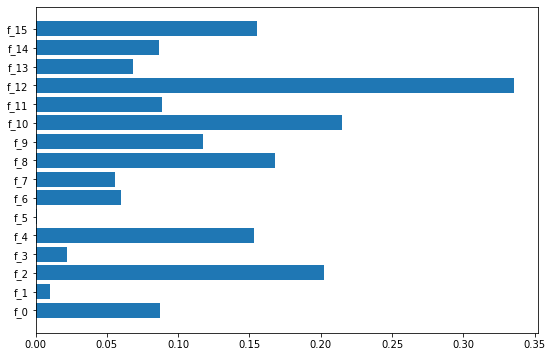

Fidelity  dectree: 0.930379746835443
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2368525108738632 samples from train set wiuth class balance: 0.5012520868113522
--- 374.8000166416168 seconds ---
IF f_9 <-0.007338910363614559 AND f_9 >=-0.3277915418148041 AND f_12 >=0.21361949294805527 AND f_10 >=-0.6008330881595612 AND f_14 >=-0.655287355184555 AND f_14 >= 0.9290412214179126 * f_9+-0.5854448602371217 THEN class = 0 # 1.0



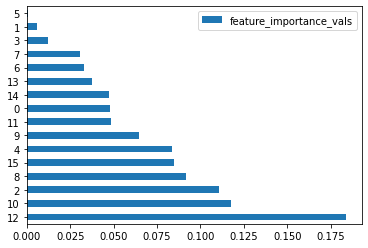

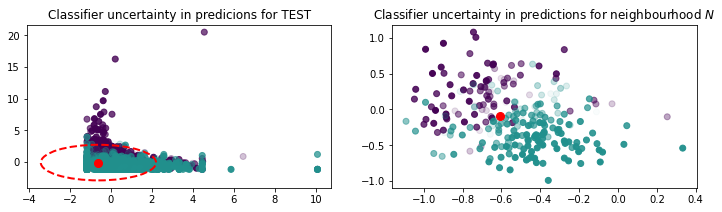

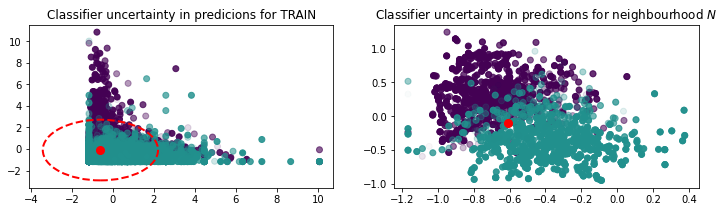

Fidelity  with shap: 0.9460317460317461
f_9<-0.007338910363614559 and f_9>=-0.3277915418148041 and f_12>=0.21361949294805527 and f_10>=-0.6008330881595612 and f_14>=-0.655287355184555 and f_14>= 0.9290412214179126 * f_9+-0.5854448602371217
f_9<-0.007338910363614559 and f_9>=-0.3277915418148041 and f_12>=0.21361949294805527 and f_10>=-0.6008330881595612 and f_14>=-0.655287355184555 and f_14>= 0.9290412214179126 * f_9+-0.5854448602371217
SHAPGAIN LUX:0.10327165319137666
Fidelity  EXPLAN: 0.8618421052631579
LORE expl e = {'f_4': ['>=0.2714250981807709'], 'f_9': ['<-0.0849832259118557'], 'f_12': ['>=-0.1509729139506817'], 'f_0': ['>=-0.10617222636938095'], 'f_13': ['>=0.06633374840021133'], 'f_14': ['<-0.5448804199695587']}
f_4>=0.2714250981807709 and f_9<-0.0849832259118557 and f_12>=-0.1509729139506817 and f_0>=-0.10617222636938095 and f_13>=0.06633374840021133 and f_14<-0.5448804199695587
f_4>=0.2714250981807709 and f_9<-0.0849832259118557 and f_12>=-0.1509729139506817 and f_0>=-0.10617

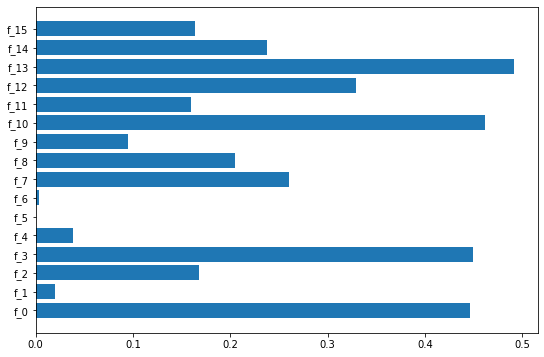

Fidelity  dectree: 0.9135802469135802
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.24120205614867538 samples from train set wiuth class balance: 0.5040983606557377
--- 346.3389239311218 seconds ---
IF f_4 >=0.03897209092974663 AND f_9 <-0.3286114037036896 AND f_12 >=-0.6585292518138885 AND f_13 >=-1.4659449458122253 AND f_10 >=-0.5720373690128326 AND f_14 >=-0.8280774354934692 THEN class = 0 # 1.0



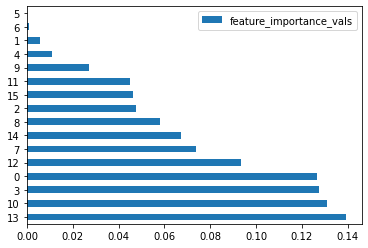

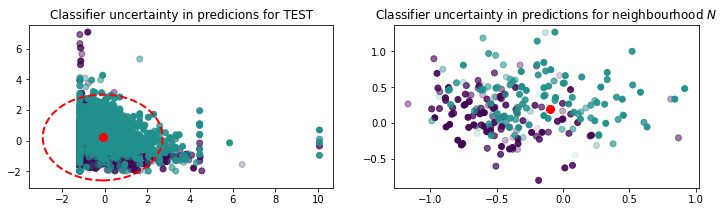

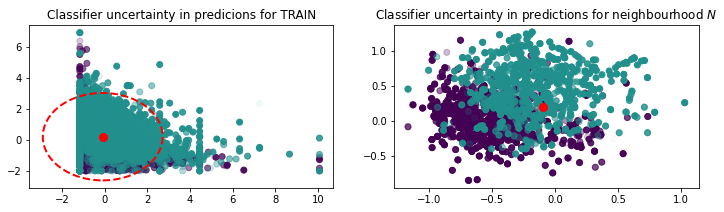

Fidelity  with shap: 0.8497854077253219
f_4>=0.03897209092974663 and f_9<-0.3286114037036896 and f_12>=-0.6585292518138885 and f_13>=-1.4659449458122253 and f_10>=-0.5720373690128326 and f_14>=-0.8280774354934692
f_4>=0.03897209092974663 and f_9<-0.3286114037036896 and f_12>=-0.6585292518138885 and f_13>=-1.4659449458122253 and f_10>=-0.5720373690128326 and f_14>=-0.8280774354934692
SHAPGAIN LUX:0.07176808657604589
Fidelity  EXPLAN: 0.7265625000000001
LORE expl e = {'f_4': ['<0.27156831324100494'], 'f_7': ['<0.498208224773407'], 'f_13': ['<-0.571788877248764', '>=-1.0529893040657043'], 'f_6': ['<0.6796885430812836']}
f_4<0.27156831324100494 and f_7<0.498208224773407 and f_13<-0.571788877248764 and f_13>=-1.0529893040657043 and f_6<0.6796885430812836
f_4<0.27156831324100494 and f_7<0.498208224773407 and f_13<-0.571788877248764 and f_13>=-1.0529893040657043 and f_6<0.6796885430812836
SHAPGAIN explan:0.05322213194187598
Fidelity  LORE: 0.4166666666666667
LORE expl e = {'f_4': ['<0.4518532

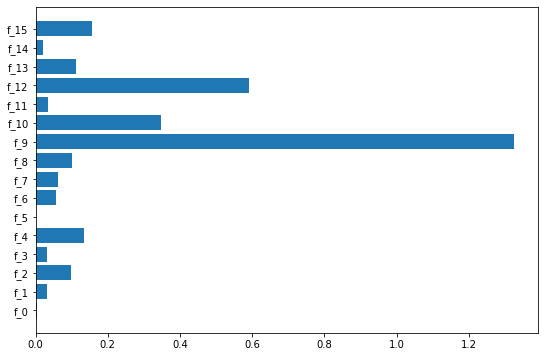

Fidelity  dectree: 0.9661399548532732
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.24159746935547646 samples from train set wiuth class balance: 0.5004091653027823
--- 306.7994387149811 seconds ---
IF f_10 >=-0.5961193740367889 AND f_14 >=-0.6568921506404877 AND f_14 >= -1.0959676282611839 * f_12+-1.393573753374632 AND f_9 <-0.2538192570209503 THEN class = 0 # 1.0



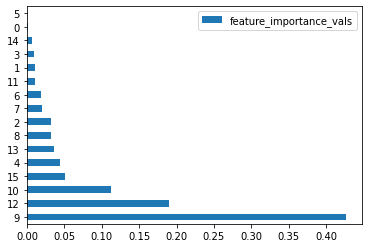

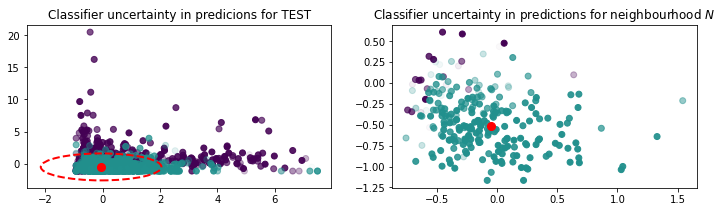

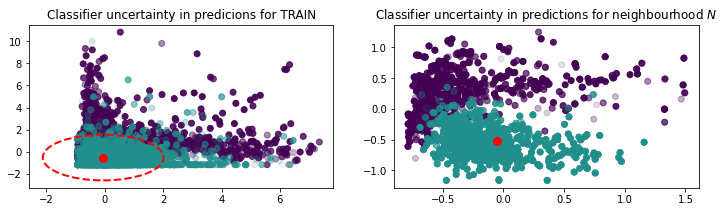

Fidelity  with shap: 0.9398148148148148
f_10>=-0.5961193740367889 and f_14>=-0.6568921506404877 and f_14>= -1.0959676282611839 * f_12+-1.393573753374632 and f_9<-0.2538192570209503
f_10>=-0.5961193740367889 and f_14>=-0.6568921506404877 and f_14>= -1.0959676282611839 * f_12+-1.393573753374632 and f_9<-0.2538192570209503
SHAPGAIN LUX:0.17939092763256018
Fidelity  EXPLAN: 0.937219730941704
LORE expl e = {'f_4': ['>=0.07837361097335815'], 'f_9': ['<0.09164714440703392'], 'f_11': ['<-0.3758458197116852'], 'f_2': ['<-0.3960147053003311'], 'f_3': ['<2.942247152328491', '>=1.3818143010139465']}
f_4>=0.07837361097335815 and f_9<0.09164714440703392 and f_11<-0.3758458197116852 and f_2<-0.3960147053003311 and f_3<2.942247152328491 and f_3>=1.3818143010139465
f_4>=0.07837361097335815 and f_9<0.09164714440703392 and f_11<-0.3758458197116852 and f_2<-0.3960147053003311 and f_3<2.942247152328491 and f_3>=1.3818143010139465
SHAPGAIN explan:0.10033081909846904
Fidelity  LORE: 0.9548387096774195
LORE e

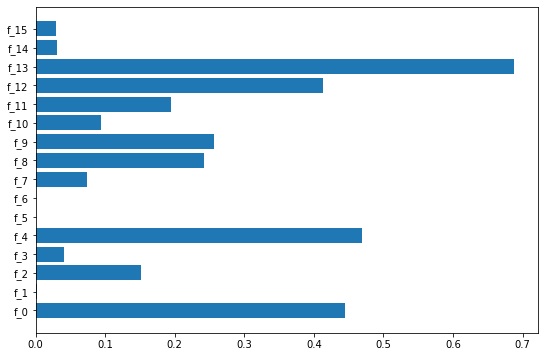

Fidelity  dectree: 0.9769392033542977
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.30189798339264534 samples from train set wiuth class balance: 0.5072036673215455
--- 384.2376148700714 seconds ---
IF f_13 <-0.6049955785274506 AND f_12 <0.3249490112066269 AND f_0 >=-0.10075029358267784 THEN class = 1 # 1.0



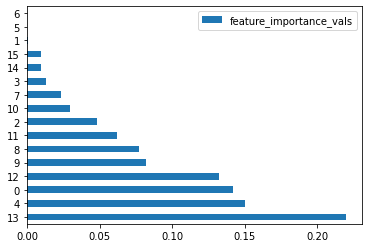

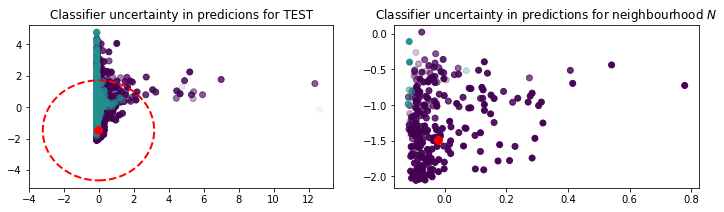

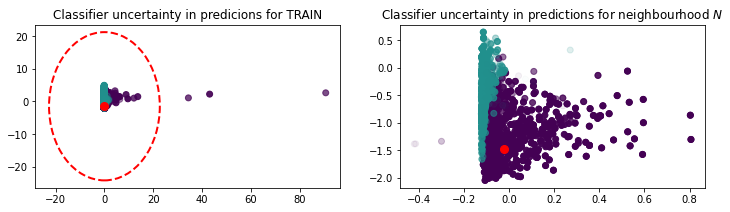

Fidelity  with shap: 0.9787234042553192
f_13<-0.6049955785274506 and f_12<0.3249490112066269 and f_0>=-0.10075029358267784
f_13<-0.6049955785274506 and f_12<0.3249490112066269 and f_0>=-0.10075029358267784
SHAPGAIN LUX:0.16454944369431432
Fidelity  EXPLAN: 0.8988764044943821
LORE expl e = {'f_0': ['>=-0.11148488521575928'], 'f_15': ['<0.014782773330807686'], 'f_9': ['>=-0.2707183361053467']}
f_0>=-0.11148488521575928 and f_15<0.014782773330807686 and f_9>=-0.2707183361053467
f_0>=-0.11148488521575928 and f_15<0.014782773330807686 and f_9>=-0.2707183361053467
SHAPGAIN explan:0.07460669215473578
Fidelity  LORE: 0.9258426966292135
LORE expl e = {'f_13': ['<-1.1123719215393066'], 'f_4': ['<0.09243036806583405'], 'f_0': ['>=-0.12134150043129921']}
Ats lore: ['f_13', 'f_4', 'f_0']
f_13<-1.1123719215393066 and f_4<0.09243036806583405 and f_0>=-0.12134150043129921
f_13<-1.1123719215393066 and f_4<0.09243036806583405 and f_0>=-0.12134150043129921
SHAPGAIN lore:0.17047870166739532
SHAPGAIN ancho

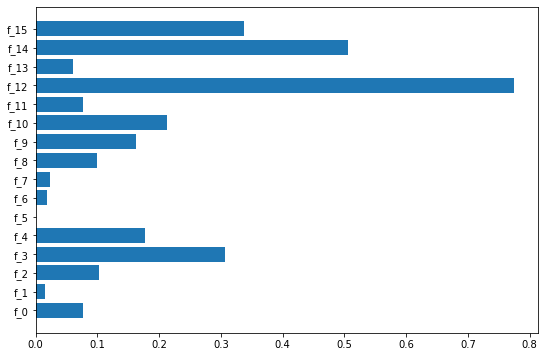

Fidelity  dectree: 0.8921568627450981
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2487149070778964 samples from train set wiuth class balance: 0.5019872813990461
--- 354.6614489555359 seconds ---
IF f_4 <0.6511291265487671 AND f_4 >=0.12352259084582329 AND f_9 <0.0022111738799139857 AND f_9 >=-0.1832103282213211 AND f_12 <0.18090040981769562 AND f_2 >=-0.3990975469350815 AND f_15 <-0.23192252218723297 AND f_13 >=-0.07718305289745331 AND f_10 >=-0.5300700068473816 AND f_14 >=-0.23833253234624863 THEN class = 1 # 1.0



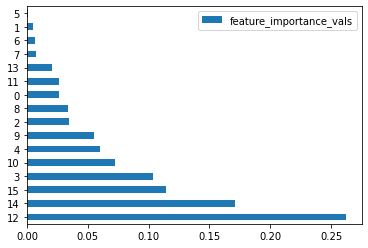

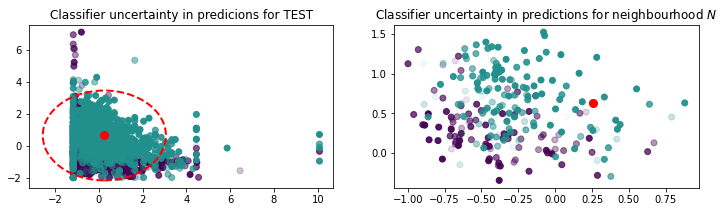

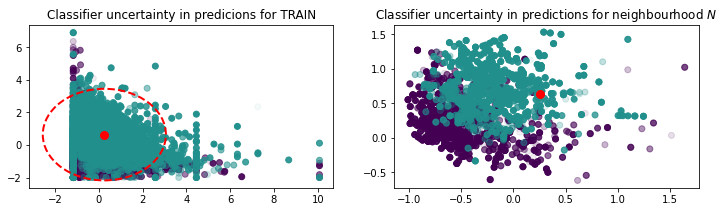

Fidelity  with shap: 0.8571428571428572
f_4<0.6511291265487671 and f_4>=0.12352259084582329 and f_9<0.0022111738799139857 and f_9>=-0.1832103282213211 and f_12<0.18090040981769562 and f_2>=-0.3990975469350815 and f_15<-0.23192252218723297 and f_13>=-0.07718305289745331 and f_10>=-0.5300700068473816 and f_14>=-0.23833253234624863
f_4<0.6511291265487671 and f_4>=0.12352259084582329 and f_9<0.0022111738799139857 and f_9>=-0.1832103282213211 and f_12<0.18090040981769562 and f_2>=-0.3990975469350815 and f_15<-0.23192252218723297 and f_13>=-0.07718305289745331 and f_10>=-0.5300700068473816 and f_14>=-0.23833253234624863
SHAPGAIN LUX:0.09623172422339371
Fidelity  EXPLAN: 0.8000000000000002
LORE expl e = {'f_4': ['>=-0.3259226381778717'], 'f_9': ['<-0.08977331221103668', '>=-0.37135808169841766'], 'f_12': ['<-0.35079120099544525'], 'f_15': ['<-0.4326416105031967'], 'f_14': ['>=-0.7314010262489319']}
f_4>=-0.3259226381778717 and f_9<-0.08977331221103668 and f_9>=-0.37135808169841766 and f_12<-0

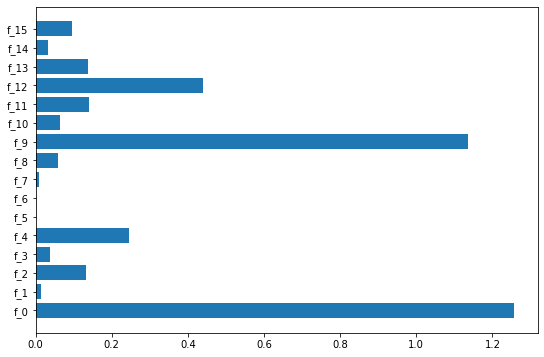

Fidelity  dectree: 0.9450549450549451
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2837089758797944 samples from train set wiuth class balance: 0.5
--- 381.7956392765045 seconds ---
IF f_7 <0.9725682735443115 AND f_9 <-0.16277023404836655 AND f_0 <-0.1115034818649292 AND f_13 >=-1.459170639514923 THEN class = 0 # 1.0



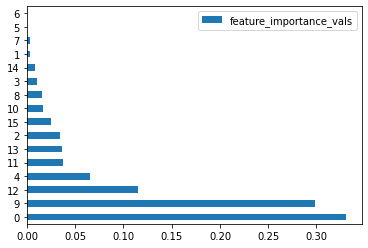

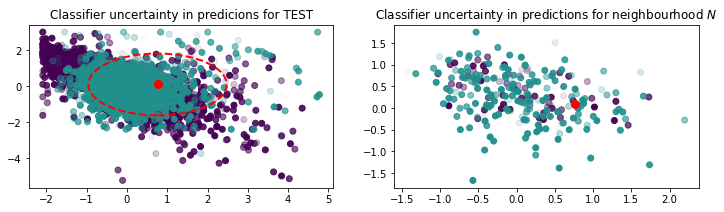

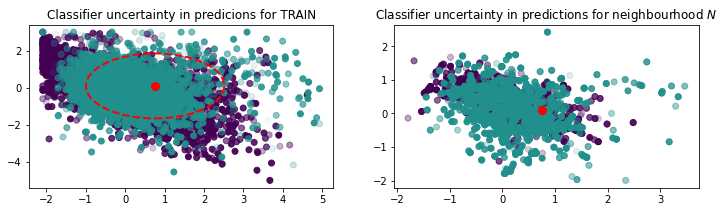

Fidelity  with shap: 0.9502762430939227
f_7<0.9725682735443115 and f_9<-0.16277023404836655 and f_0<-0.1115034818649292 and f_13>=-1.459170639514923
f_7<0.9725682735443115 and f_9<-0.16277023404836655 and f_0<-0.1115034818649292 and f_13>=-1.459170639514923
SHAPGAIN LUX:0.16636586178529061
Fidelity  EXPLAN: 0.9389920424403184
LORE expl e = {'f_13': ['>=-0.5125115513801575'], 'f_0': ['<-0.0954776257276535'], 'f_9': ['<-0.251798078417778']}
f_13>=-0.5125115513801575 and f_0<-0.0954776257276535 and f_9<-0.251798078417778
f_13>=-0.5125115513801575 and f_0<-0.0954776257276535 and f_9<-0.251798078417778
SHAPGAIN explan:0.22182114904705416
Fidelity  LORE: 0.925207756232687
LORE expl e = {'f_0': ['<-0.10310985520482063'], 'f_9': ['<-0.006479119881987572']}
Ats lore: ['f_0', 'f_9']
f_0<-0.10310985520482063 and f_9<-0.006479119881987572
f_0<-0.10310985520482063 and f_9<-0.006479119881987572
SHAPGAIN lore:0.31467276941526445
SHAPGAIN anchor:0.22182114904705416
Anchor explanation: {'f_9': ['<=-0.5

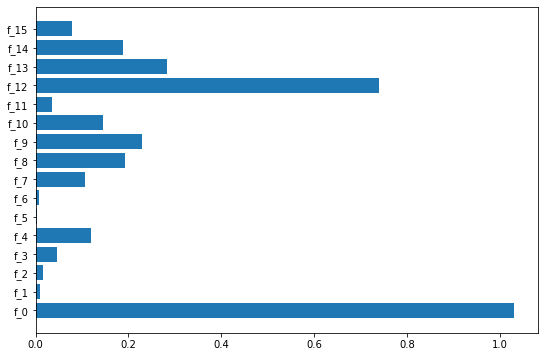

Fidelity  dectree: 0.9618320610687022
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.25227362593910635 samples from train set wiuth class balance: 0.5003918495297806
--- 363.82072830200195 seconds ---
IF f_4 >=-0.27050434052944183 AND f_9 <0.17868658155202866 AND f_9 >=-1.2572197914123535 AND f_12 >=-0.5889149010181427 AND f_2 >=1.9519945979118347 AND f_10 >=-0.46162545680999756 THEN class = 0 # 0.999003984063745



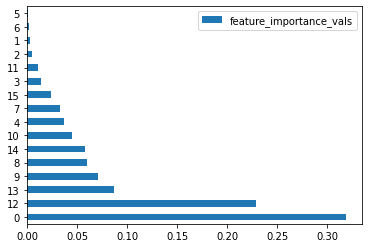

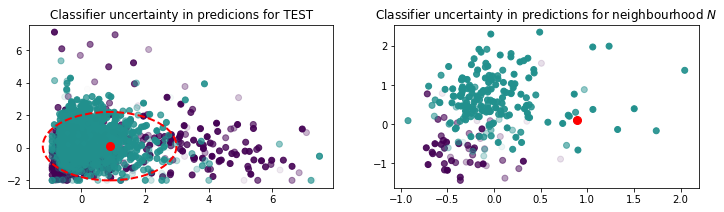

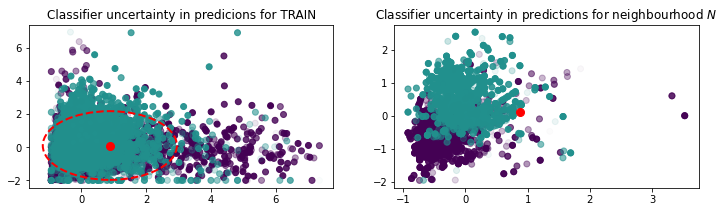

Fidelity  with shap: 0.8467966573816155
f_4>=-0.27050434052944183 and f_9<0.17868658155202866 and f_9>=-1.2572197914123535 and f_12>=-0.5889149010181427 and f_2>=1.9519945979118347 and f_10>=-0.46162545680999756
f_4>=-0.27050434052944183 and f_9<0.17868658155202866 and f_9>=-1.2572197914123535 and f_12>=-0.5889149010181427 and f_2>=1.9519945979118347 and f_10>=-0.46162545680999756
SHAPGAIN LUX:0.07636617036335804
Fidelity  EXPLAN: 0.9460154241645244
LORE expl e = {'f_9': ['>=-0.09870496392250061'], 'f_11': ['>=-0.1829443871974945'], 'f_12': ['>=0.31285837292671204'], 'f_0': ['<-0.11487580835819244'], 'f_13': ['>=-1.23068106174469'], 'f_10': ['<1.9377089738845825']}
f_9>=-0.09870496392250061 and f_11>=-0.1829443871974945 and f_12>=0.31285837292671204 and f_0<-0.11487580835819244 and f_13>=-1.23068106174469 and f_10<1.9377089738845825
f_9>=-0.09870496392250061 and f_11>=-0.1829443871974945 and f_12>=0.31285837292671204 and f_0<-0.11487580835819244 and f_13>=-1.23068106174469 and f_10<1.9

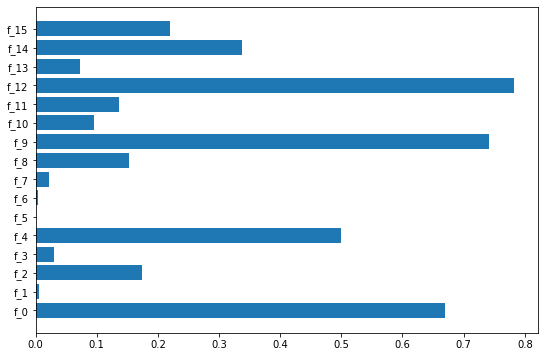

Fidelity  dectree: 0.991869918699187
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.38908659549228947 samples from train set wiuth class balance: 0.5213414634146342
--- 543.4713687896729 seconds ---
IF f_4 <0.03137771226465702 AND f_9 >=0.2327781617641449 AND f_12 <0.3274075835943222 AND f_0 >=-0.111857570707798 AND f_14 <0.2891278862953186 THEN class = 1 # 1.0



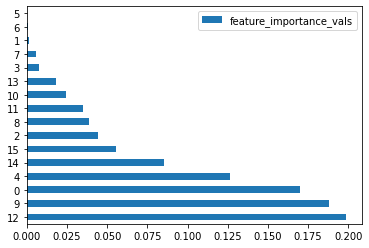

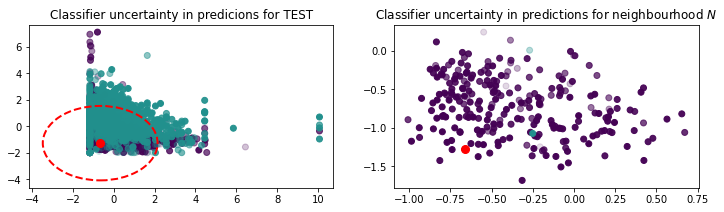

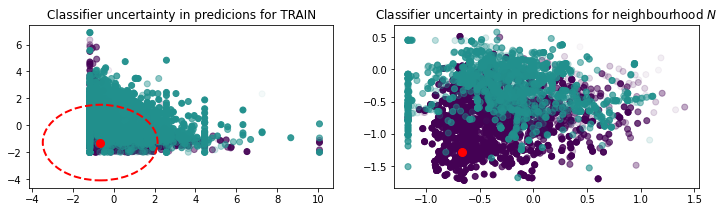

Fidelity  with shap: 0.9753086419753085
f_4<0.03137771226465702 and f_9>=0.2327781617641449 and f_12<0.3274075835943222 and f_0>=-0.111857570707798 and f_14<0.2891278862953186
f_4<0.03137771226465702 and f_9>=0.2327781617641449 and f_12<0.3274075835943222 and f_0>=-0.111857570707798 and f_14<0.2891278862953186
SHAPGAIN LUX:0.15376648326888925
Fidelity  EXPLAN: 0.9898580121703855
LORE expl e = {'f_12': ['<0.3142746388912201'], 'f_0': ['>=-0.11496879160404205'], 'f_9': ['>=-0.015829583629965782']}
f_12<0.3142746388912201 and f_0>=-0.11496879160404205 and f_9>=-0.015829583629965782
f_12<0.3142746388912201 and f_0>=-0.11496879160404205 and f_9>=-0.015829583629965782
SHAPGAIN explan:0.18556473865622192
Fidelity  LORE: 0.98989898989899
LORE expl e = {'f_0': ['>=-0.12142828851938248'], 'f_9': ['>=0.13047699257731438'], 'f_11': ['<1.8339130878448486']}
Ats lore: ['f_0', 'f_9', 'f_11']
f_0>=-0.12142828851938248 and f_9>=0.13047699257731438 and f_11<1.8339130878448486
f_0>=-0.12142828851938248 a

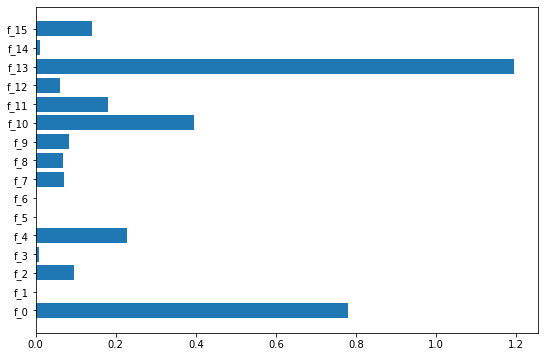

Fidelity  dectree: 0.9612756264236901
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2530644523527086 samples from train set wiuth class balance: 0.503515625
--- 308.0333390235901 seconds ---
IF f_13 <-0.8730452060699463 AND f_12 <0.34836021065711975 AND f_0 >=-0.10537873581051826 THEN class = 1 # 1.0



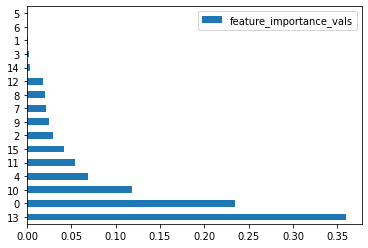

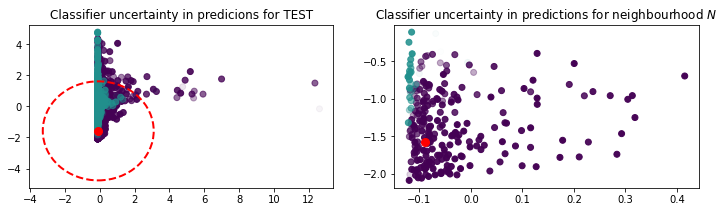

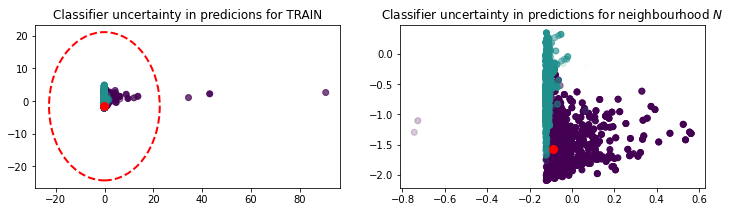

Fidelity  with shap: 0.9557109557109557
f_13<-0.8730452060699463 and f_12<0.34836021065711975 and f_0>=-0.10537873581051826
f_13<-0.8730452060699463 and f_12<0.34836021065711975 and f_0>=-0.10537873581051826
SHAPGAIN LUX:0.19808574524458253
Fidelity  EXPLAN: 0.9709172259507831
LORE expl e = {'f_4': ['<0.03496718034148216'], 'f_0': ['>=-0.11191262304782867'], 'f_13': ['<-0.6011188626289368']}
f_4<0.03496718034148216 and f_0>=-0.11191262304782867 and f_13<-0.6011188626289368
f_4<0.03496718034148216 and f_0>=-0.11191262304782867 and f_13<-0.6011188626289368
SHAPGAIN explan:0.22088563346038084
Fidelity  LORE: 0.9555555555555557
LORE expl e = {'f_13': ['<-1.2085782885551453'], 'f_4': ['<0.625730574131012']}
Ats lore: ['f_13', 'f_4']
f_13<-1.2085782885551453 and f_4<0.625730574131012
f_13<-1.2085782885551453 and f_4<0.625730574131012
SHAPGAIN lore:0.2140149650575505
SHAPGAIN anchor:0.17825218465758974
Anchor explanation: {'f_13': ['<=-0.65'], 'f_10': ['<=-0.56'], 'f_0': ['>-0.10'], 'f_5': ['

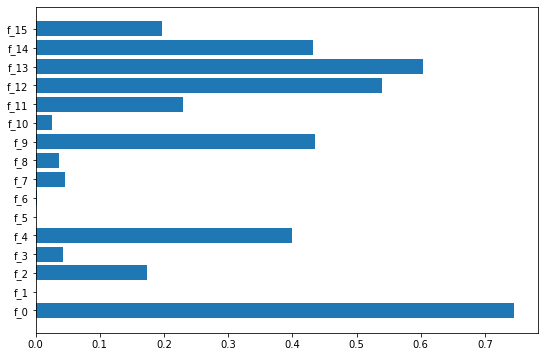

Fidelity  dectree: 0.9696969696969696
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.28410438908659547 samples from train set wiuth class balance: 0.5038274182324287
--- 397.3942587375641 seconds ---
IF f_4 <-0.1547689288854599 AND f_12 <0.3544500917196274 AND f_0 >=-0.10569656267762184 AND f_13 <-0.6892735362052917 THEN class = 1 # 1.0



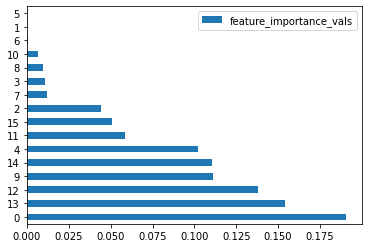

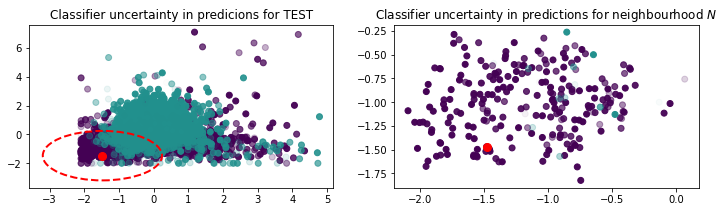

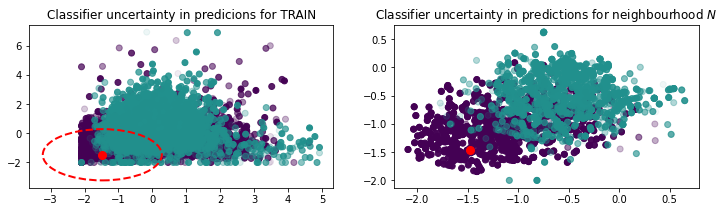

Fidelity  with shap: 0.9761388286334056
f_4<-0.1547689288854599 and f_12<0.3544500917196274 and f_0>=-0.10569656267762184 and f_13<-0.6892735362052917
f_4<-0.1547689288854599 and f_12<0.3544500917196274 and f_0>=-0.10569656267762184 and f_13<-0.6892735362052917
SHAPGAIN LUX:0.14618930757973483
Fidelity  EXPLAN: 0.9612068965517242
LORE expl e = {'f_4': ['<0.779663473367691'], 'f_7': ['>=-0.8457306623458862'], 'f_5': ['<1.2412490844726562'], 'f_0': ['>=-0.11639459431171417'], 'f_13': ['<-0.6492290496826172'], 'f_14': ['<0.45388223230838776']}
f_4<0.779663473367691 and f_7>=-0.8457306623458862 and f_5<1.2412490844726562 and f_0>=-0.11639459431171417 and f_13<-0.6492290496826172 and f_14<0.45388223230838776
f_4<0.779663473367691 and f_7>=-0.8457306623458862 and f_5<1.2412490844726562 and f_0>=-0.11639459431171417 and f_13<-0.6492290496826172 and f_14<0.45388223230838776
SHAPGAIN explan:0.09486802336248656
Fidelity  LORE: 0.9527896995708155
LORE expl e = {'f_12': ['<0.27954359352588654'], '

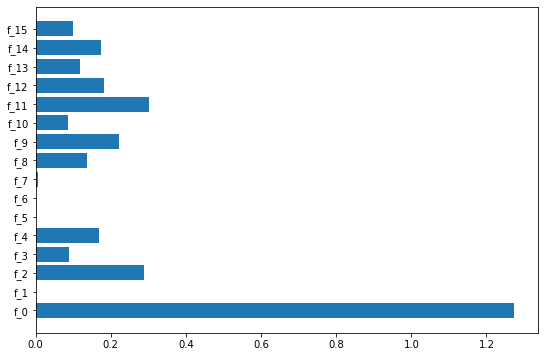

Fidelity  dectree: 0.7999999999999999
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.22044286279161723 samples from train set wiuth class balance: 0.5044843049327354
--- 301.4002830982208 seconds ---
IF f_9 <0.19217294454574585 AND f_9 >=-0.3075595647096634 AND f_11 <-0.3722595274448395 AND f_12 <0.3014163672924042 AND f_0 <-0.11119972169399261 AND f_0 >=-0.187727190554142 THEN class = 0 # 1.0



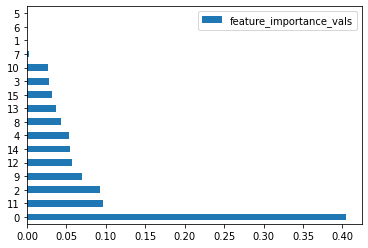

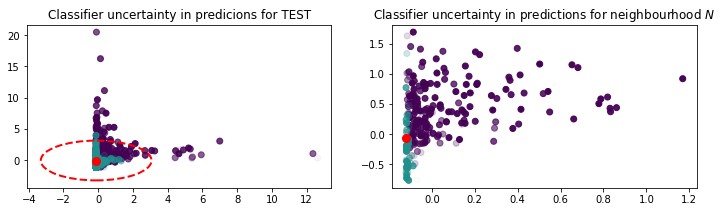

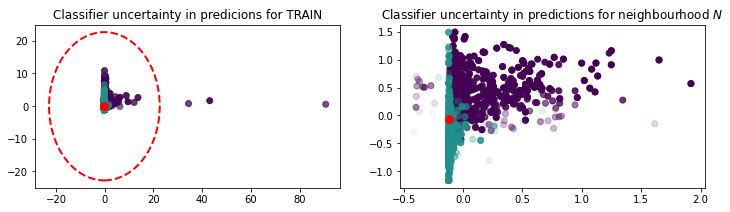

Fidelity  with shap: 0.8034188034188035
f_9<0.19217294454574585 and f_9>=-0.3075595647096634 and f_11<-0.3722595274448395 and f_12<0.3014163672924042 and f_0<-0.11119972169399261 and f_0>=-0.187727190554142
f_9<0.19217294454574585 and f_9>=-0.3075595647096634 and f_11<-0.3722595274448395 and f_12<0.3014163672924042 and f_0<-0.11119972169399261 and f_0>=-0.187727190554142
SHAPGAIN LUX:0.15715299962706156
Fidelity  EXPLAN: 0.711111111111111
LORE expl e = {'f_4': ['>=-0.8263672888278961'], 'f_9': ['>=-0.17736709117889404'], 'f_12': ['<0.28416767716407776'], 'f_0': ['<-0.1132330372929573', '>=-0.12244494631886482'], 'f_14': ['>=0.019519456662237644']}
f_4>=-0.8263672888278961 and f_9>=-0.17736709117889404 and f_12<0.28416767716407776 and f_0<-0.1132330372929573 and f_0>=-0.12244494631886482 and f_14>=0.019519456662237644
f_4>=-0.8263672888278961 and f_9>=-0.17736709117889404 and f_12<0.28416767716407776 and f_0<-0.1132330372929573 and f_0>=-0.12244494631886482 and f_14>=0.01951945666223764

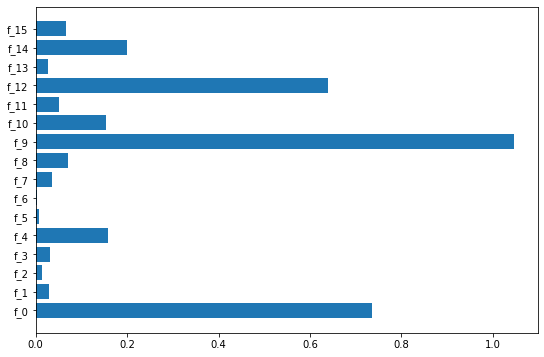

Fidelity  dectree: 0.9595959595959596
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.24673784104389088 samples from train set wiuth class balance: 0.4987980769230769
--- 331.50814986228943 seconds ---
IF f_4 >=-0.2207600697875023 AND f_9 <-0.3819078356027603 AND f_9 < 0.8867669125399472 * f_12+0.2635164827388249 AND f_2 >=1.9519945979118347 AND f_13 >=-1.2400072813034058 THEN class = 0 # 1.0



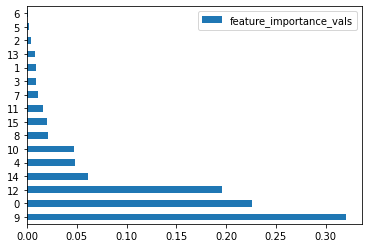

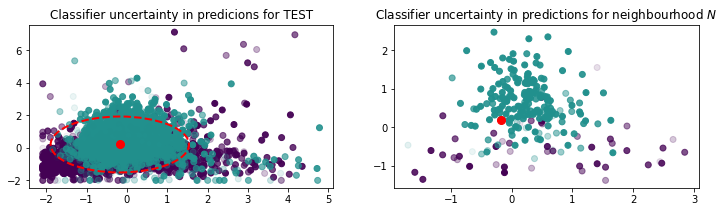

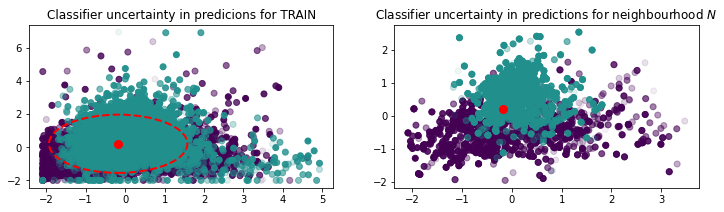

Fidelity  with shap: 0.927461139896373
f_4>=-0.2207600697875023 and f_9<-0.3819078356027603 and f_9< 0.8867669125399472 * f_12+0.2635164827388249 and f_2>=1.9519945979118347 and f_13>=-1.2400072813034058
f_4>=-0.2207600697875023 and f_9<-0.3819078356027603 and f_9< 0.8867669125399472 * f_12+0.2635164827388249 and f_2>=1.9519945979118347 and f_13>=-1.2400072813034058
SHAPGAIN LUX:0.092134847763644
Fidelity  EXPLAN: 0.9593908629441624
LORE expl e = {'f_9': ['<-0.37842538952827454'], 'f_0': ['<-0.10596765577793121'], 'f_3': ['<5.011371612548828'], 'f_13': ['>=-0.29918892681598663'], 'f_14': ['>=-0.7215559482574463']}
f_9<-0.37842538952827454 and f_0<-0.10596765577793121 and f_3<5.011371612548828 and f_13>=-0.29918892681598663 and f_14>=-0.7215559482574463
f_9<-0.37842538952827454 and f_0<-0.10596765577793121 and f_3<5.011371612548828 and f_13>=-0.29918892681598663 and f_14>=-0.7215559482574463
SHAPGAIN explan:0.12138886027309255
Fidelity  LORE: 0.9166666666666667
LORE expl e = {'f_4': ['>

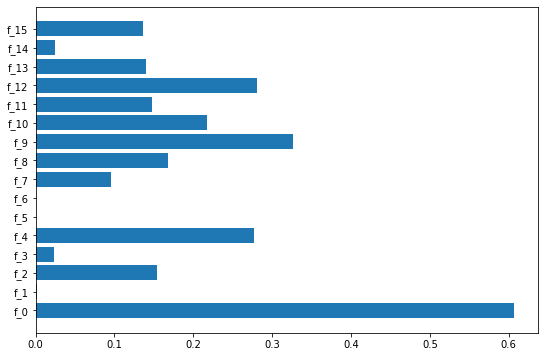

Fidelity  dectree: 0.9662921348314607
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.25662317121391853 samples from train set wiuth class balance: 0.5073189522342064
--- 341.58521127700806 seconds ---
IF f_9 >=-0.4292101711034775 AND f_12 <0.32508429884910583 AND f_0 >=-0.09859072789549828 AND f_13 <-0.26969777047634125 AND f_13 < 1.2089776278653837 * f_9+0.24243688340885364 THEN class = 1 # 0.9987577639751553



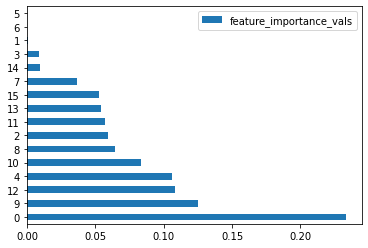

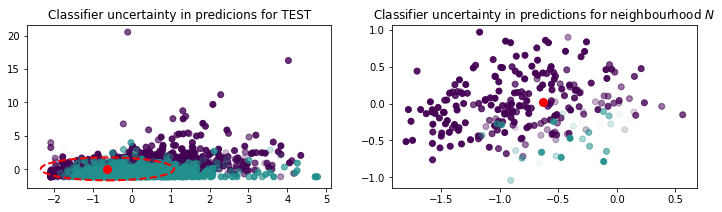

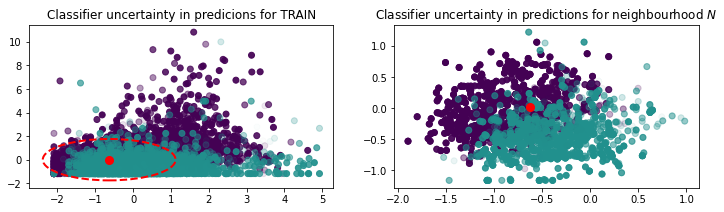

Fidelity  with shap: 0.9631336405529954
f_9>=-0.4292101711034775 and f_12<0.32508429884910583 and f_0>=-0.09859072789549828 and f_13<-0.26969777047634125 and f_13< 1.2089776278653837 * f_9+0.24243688340885364
f_9>=-0.4292101711034775 and f_12<0.32508429884910583 and f_0>=-0.09859072789549828 and f_13<-0.26969777047634125 and f_13< 1.2089776278653837 * f_9+0.24243688340885364
SHAPGAIN LUX:0.1302013214571204
Fidelity  EXPLAN: 0.9464285714285714
LORE expl e = {'f_4': ['<0.057586219161748886'], 'f_9': ['<0.2384757101535797', '>=-0.10027559474110603'], 'f_0': ['>=-0.11315864697098732'], 'f_13': ['<-0.20572952181100845'], 'f_14': ['>=-0.07930097728967667']}
f_4<0.057586219161748886 and f_9<0.2384757101535797 and f_9>=-0.10027559474110603 and f_0>=-0.11315864697098732 and f_13<-0.20572952181100845 and f_14>=-0.07930097728967667
f_4<0.057586219161748886 and f_9<0.2384757101535797 and f_9>=-0.10027559474110603 and f_0>=-0.11315864697098732 and f_13<-0.20572952181100845 and f_14>=-0.079300977289

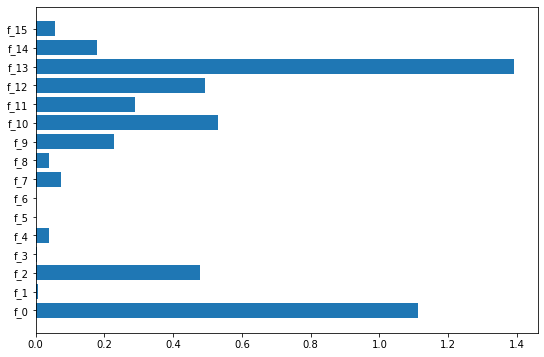

Fidelity  dectree: 0.816
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.22558323448003165 samples from train set wiuth class balance: 0.5
--- 295.68728852272034 seconds ---
IF f_13 <-1.4576464295387268 AND f_10 <-0.2270600125193596 AND f_0 <-0.10770617797970772 THEN class = 1 # 1.0



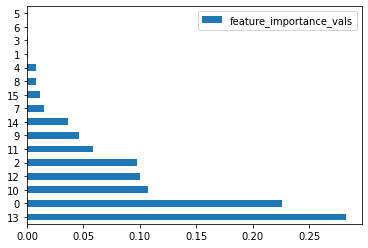

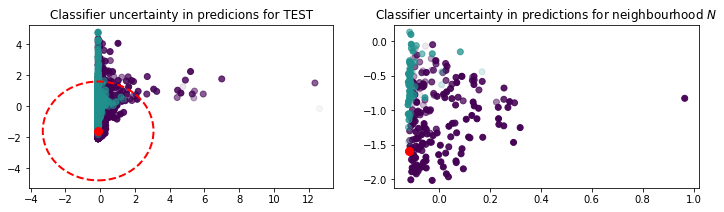

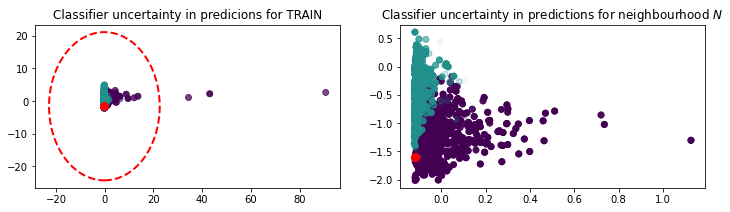

Fidelity  with shap: 0.7972027972027973
f_13<-1.4576464295387268 and f_10<-0.2270600125193596 and f_0<-0.10770617797970772
f_13<-1.4576464295387268 and f_10<-0.2270600125193596 and f_0<-0.10770617797970772
SHAPGAIN LUX:0.20552983314822146
Fidelity  EXPLAN: 0.553191489361702
LORE expl e = {'f_4': ['<1.1072252988815308', '>=-1.1421792209148407'], 'f_7': ['>=-1.193692684173584'], 'f_9': ['<-0.2323184460401535'], 'f_11': ['<-0.40032337605953217'], 'f_15': ['>=-0.6997723877429962'], 'f_0': ['<-0.11415670812129974'], 'f_13': ['<-0.5011795312166214']}
f_4<1.1072252988815308 and f_4>=-1.1421792209148407 and f_7>=-1.193692684173584 and f_9<-0.2323184460401535 and f_11<-0.40032337605953217 and f_15>=-0.6997723877429962 and f_0<-0.11415670812129974 and f_13<-0.5011795312166214
f_4<1.1072252988815308 and f_4>=-1.1421792209148407 and f_7>=-1.193692684173584 and f_9<-0.2323184460401535 and f_11<-0.40032337605953217 and f_15>=-0.6997723877429962 and f_0<-0.11415670812129974 and f_13<-0.50117953121662

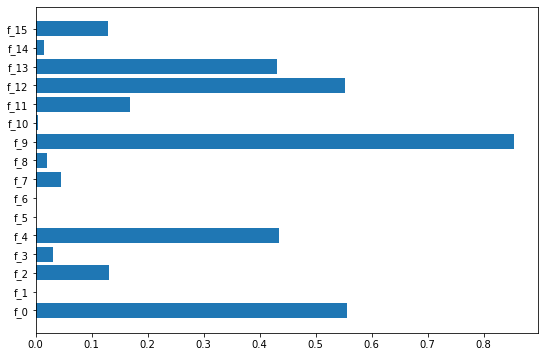

Fidelity  dectree: 0.9834710743801652
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2973507315144326 samples from train set wiuth class balance: 0.5066489361702128
--- 339.8279960155487 seconds ---
IF f_13 <-0.4405759572982788 AND f_13 < 0.94886803388092 * f_9+0.13172151142996 AND f_12 <0.32053515315055847 AND f_0 >=-0.09515636786818504 THEN class = 1 # 1.0



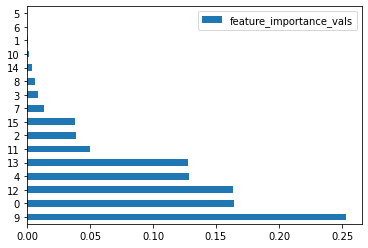

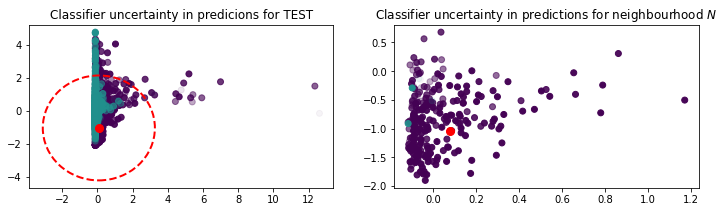

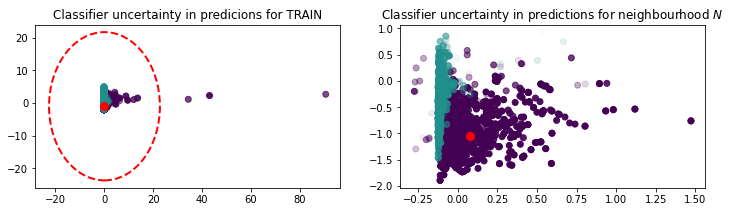

Fidelity  with shap: 0.9708333333333332
f_13<-0.4405759572982788 and f_13< 0.94886803388092 * f_9+0.13172151142996 and f_12<0.32053515315055847 and f_0>=-0.09515636786818504
f_13<-0.4405759572982788 and f_13< 0.94886803388092 * f_9+0.13172151142996 and f_12<0.32053515315055847 and f_0>=-0.09515636786818504
SHAPGAIN LUX:0.15203302446630315
Fidelity  EXPLAN: 0.9773195876288661
LORE expl e = {'f_1': ['>=-0.6316063702106476'], 'f_9': ['>=0.09284479916095734'], 'f_12': ['<0.31406375765800476'], 'f_3': ['<-1.3469266891479492'], 'f_13': ['<1.3534401655197144'], 'f_14': ['<0.19263377040624619']}
f_1>=-0.6316063702106476 and f_9>=0.09284479916095734 and f_12<0.31406375765800476 and f_3<-1.3469266891479492 and f_13<1.3534401655197144 and f_14<0.19263377040624619
f_1>=-0.6316063702106476 and f_9>=0.09284479916095734 and f_12<0.31406375765800476 and f_3<-1.3469266891479492 and f_13<1.3534401655197144 and f_14<0.19263377040624619
SHAPGAIN explan:0.09226799012492942
Fidelity  LORE: 0.890380313199105

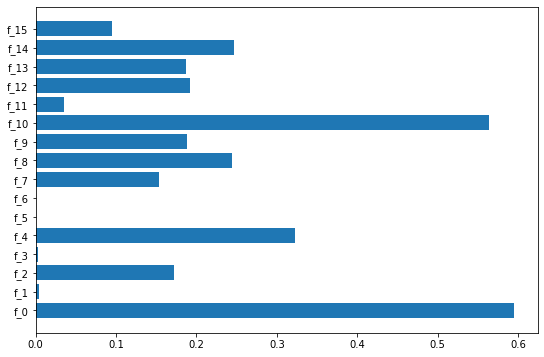

Fidelity  dectree: 0.9408602150537634
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.22973507315144326 samples from train set wiuth class balance: 0.5021514629948365
--- 339.80111503601074 seconds ---
IF f_4 <-0.0761893130838871 AND f_12 <0.32475893199443817 AND f_0 >=-0.1037415862083435 AND f_13 <-0.5704749822616577 THEN class = 1 # 1.0



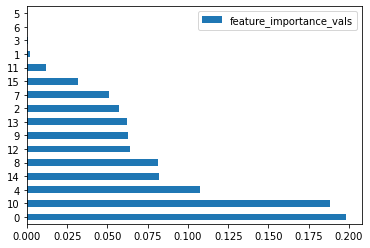

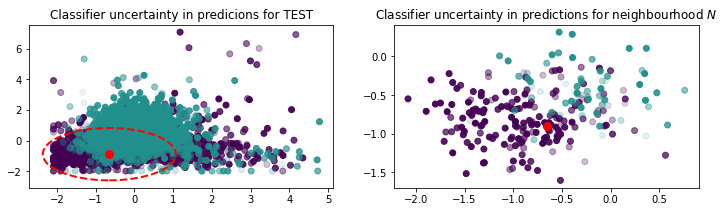

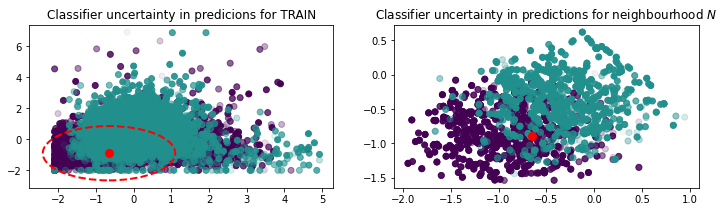

Fidelity  with shap: 0.9421487603305785
f_4<-0.0761893130838871 and f_12<0.32475893199443817 and f_0>=-0.1037415862083435 and f_13<-0.5704749822616577
f_4<-0.0761893130838871 and f_12<0.32475893199443817 and f_0>=-0.1037415862083435 and f_13<-0.5704749822616577
SHAPGAIN LUX:0.1078882932397767
Fidelity  EXPLAN: 0.9013333333333332
LORE expl e = {'f_4': ['<-0.030889169313013554'], 'f_9': ['>=-1.0567638874053955'], 'f_0': ['>=-0.11118112504482269'], 'f_13': ['<-0.5635302066802979']}
f_4<-0.030889169313013554 and f_9>=-1.0567638874053955 and f_0>=-0.11118112504482269 and f_13<-0.5635302066802979
f_4<-0.030889169313013554 and f_9>=-1.0567638874053955 and f_0>=-0.11118112504482269 and f_13<-0.5635302066802979
SHAPGAIN explan:0.1075497145071432
Fidelity  LORE: 0.8924731182795699
LORE expl e = {'f_4': ['<0.25768930464982986'], 'f_0': ['>=-0.10953215509653091'], 'f_13': ['<-0.3216705620288849'], 'f_10': ['<-0.38067884743213654']}
Ats lore: ['f_4', 'f_0', 'f_13', 'f_10']
f_4<0.25768930464982986 a

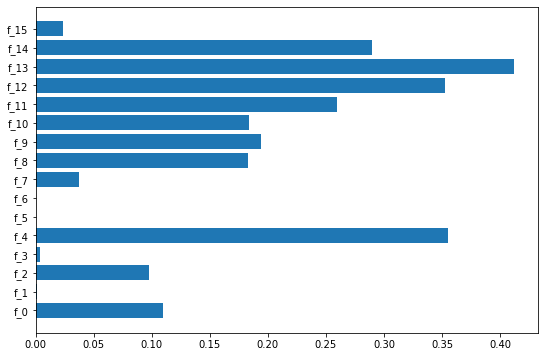

Fidelity  dectree: 0.9367088607594937
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.26729932779754845 samples from train set wiuth class balance: 0.5025887573964497
--- 388.5142271518707 seconds ---
IF f_13 <-0.4672887474298477 AND f_13 < 1.2057519807174166 * f_9+-0.34577981718107265 AND f_13 < -1.1377319149327971 * f_4+-0.9249860544016612 AND f_13 >=-1.2115147709846497 AND f_0 <-0.10577548295259476 AND f_0 >=-0.11120592057704926 THEN class = 1 # 1.0



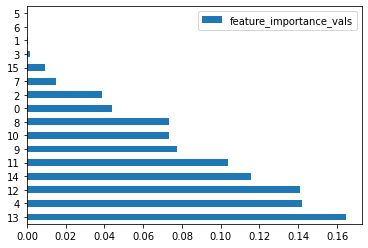

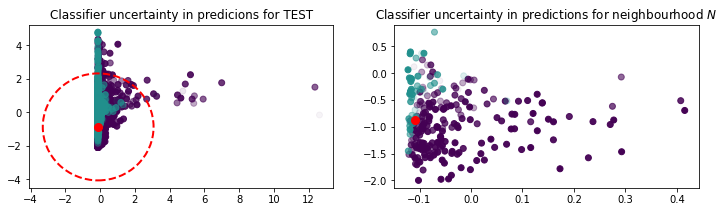

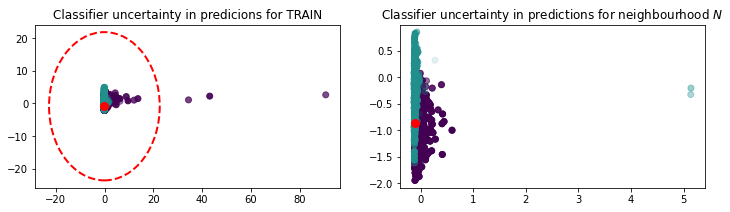

Fidelity  with shap: 0.9567430025445293
f_13<-0.4672887474298477 and f_13< 1.2057519807174166 * f_9+-0.34577981718107265 and f_13< -1.1377319149327971 * f_4+-0.9249860544016612 and f_13>=-1.2115147709846497 and f_0<-0.10577548295259476 and f_0>=-0.11120592057704926
f_13<-0.4672887474298477 and f_13< 1.2057519807174166 * f_9+-0.34577981718107265 and f_13< -1.1377319149327971 * f_4+-0.9249860544016612 and f_13>=-1.2115147709846497 and f_0<-0.10577548295259476 and f_0>=-0.11120592057704926
SHAPGAIN LUX:0.10426240851724264
Fidelity  EXPLAN: 0.9471153846153846
LORE expl e = {'f_4': ['<0.19222676753997803'], 'f_7': ['>=0.13006795197725296'], 'f_12': ['<0.36276471614837646'], 'f_0': ['>=-0.11404898017644882'], 'f_13': ['<-0.40075865387916565']}
f_4<0.19222676753997803 and f_7>=0.13006795197725296 and f_12<0.36276471614837646 and f_0>=-0.11404898017644882 and f_13<-0.40075865387916565
f_4<0.19222676753997803 and f_7>=0.13006795197725296 and f_12<0.36276471614837646 and f_0>=-0.1140489801764488

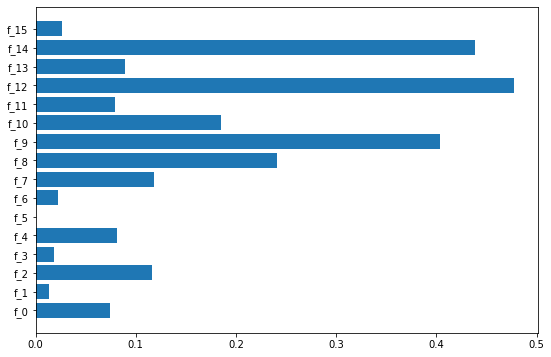

Fidelity  dectree: 0.9191489361702128
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.21431395808620007 samples from train set wiuth class balance: 0.49907749077490776
--- 284.58106231689453 seconds ---
IF f_12 >=0.31595610082149506 AND f_9 <0.4418831765651703 AND f_9 >=0.17381668835878372 AND f_9 >= -3.2889814576942022 * f_15+-1.7192901248565542 AND f_14 >=-0.49901069700717926 THEN class = 0 # 1.0



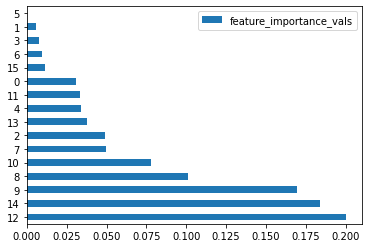

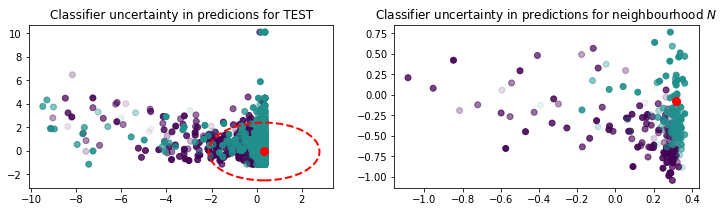

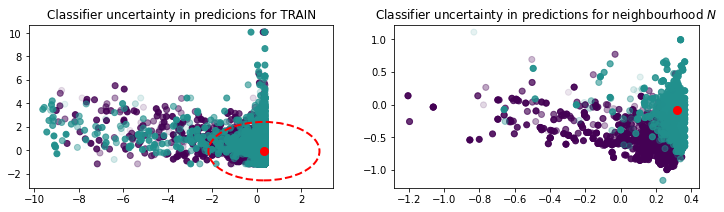

Fidelity  with shap: 0.9032258064516129
f_12>=0.31595610082149506 and f_9<0.4418831765651703 and f_9>=0.17381668835878372 and f_9>= -3.2889814576942022 * f_15+-1.7192901248565542 and f_14>=-0.49901069700717926
f_12>=0.31595610082149506 and f_9<0.4418831765651703 and f_9>=0.17381668835878372 and f_9>= -3.2889814576942022 * f_15+-1.7192901248565542 and f_14>=-0.49901069700717926
SHAPGAIN LUX:0.18440404378422467
Fidelity  EXPLAN: 0.6702127659574468
LORE expl e = {'f_11': ['>=0.5966095626354218'], 'f_12': ['>=-0.8574669361114502'], 'f_15': ['>=-0.18495283275842667'], 'f_0': ['>=-0.004667637549573556'], 'f_3': ['>=-0.11710868403315544'], 'f_10': ['<1.4186561703681946']}
f_11>=0.5966095626354218 and f_12>=-0.8574669361114502 and f_15>=-0.18495283275842667 and f_0>=-0.004667637549573556 and f_3>=-0.11710868403315544 and f_10<1.4186561703681946
f_11>=0.5966095626354218 and f_12>=-0.8574669361114502 and f_15>=-0.18495283275842667 and f_0>=-0.004667637549573556 and f_3>=-0.11710868403315544 and 

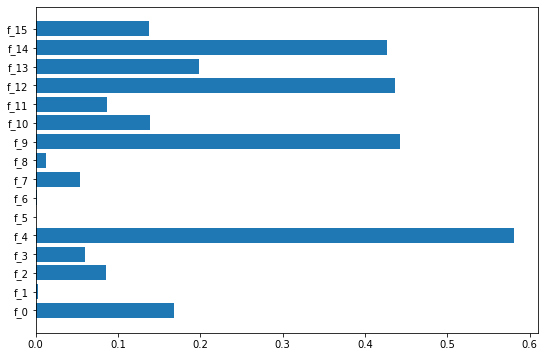

Fidelity  dectree: 0.9371428571428572
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2625543693159352 samples from train set wiuth class balance: 0.5060240963855421
--- 390.60146021842957 seconds ---
IF f_4 <-0.9574487507343292 AND f_9 <-0.08349386602640152 AND f_9 < 0.3257849535037569 * f_13+-0.4072572650737243 AND f_15 >=-0.2950131371617317 AND f_0 <-0.1030748225748539 AND f_0 >=-0.11249534040689468 THEN class = 0 # 1.0



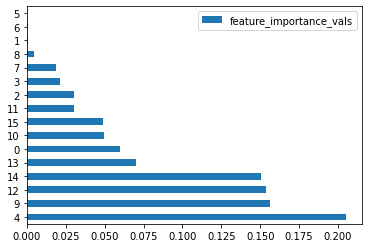

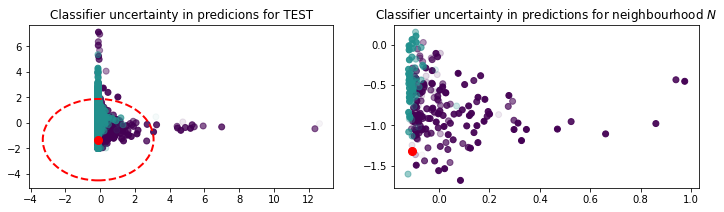

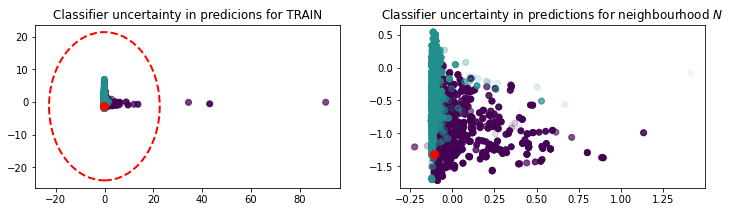

Fidelity  with shap: 0.9298245614035089
f_4<-0.9574487507343292 and f_9<-0.08349386602640152 and f_9< 0.3257849535037569 * f_13+-0.4072572650737243 and f_15>=-0.2950131371617317 and f_0<-0.1030748225748539 and f_0>=-0.11249534040689468
f_4<-0.9574487507343292 and f_9<-0.08349386602640152 and f_9< 0.3257849535037569 * f_13+-0.4072572650737243 and f_15>=-0.2950131371617317 and f_0<-0.1030748225748539 and f_0>=-0.11249534040689468
SHAPGAIN LUX:0.11736006348286852
Fidelity  EXPLAN: 0.8939828080229226
LORE expl e = {'f_4': ['<-0.8601111769676208'], 'f_8': ['<0.8827975988388062'], 'f_9': ['<-0.13173561543226242', '>=-0.37466371059417725'], 'f_0': ['>=-0.10820553824305534']}
f_4<-0.8601111769676208 and f_8<0.8827975988388062 and f_9<-0.13173561543226242 and f_9>=-0.37466371059417725 and f_0>=-0.10820553824305534
f_4<-0.8601111769676208 and f_8<0.8827975988388062 and f_9<-0.13173561543226242 and f_9>=-0.37466371059417725 and f_0>=-0.10820553824305534
SHAPGAIN explan:0.10517243619080481
Fidelit

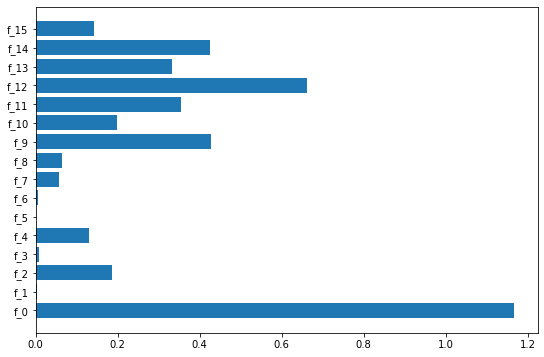

Fidelity  dectree: 0.7474747474747475
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.23527085804665876 samples from train set wiuth class balance: 0.5042016806722689
--- 348.5466105937958 seconds ---
IF f_9 <0.32146312296390533 AND f_9 >=-0.23029173910617828 AND f_11 <-0.39697059988975525 AND f_12 >=0.28891198337078094 AND f_0 <-0.10694513469934464 AND f_14 <-0.1787041276693344 THEN class = 0 # 1.0



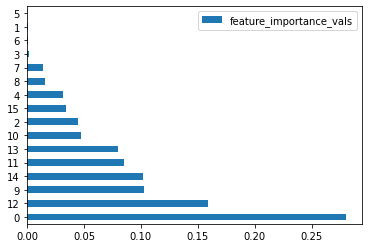

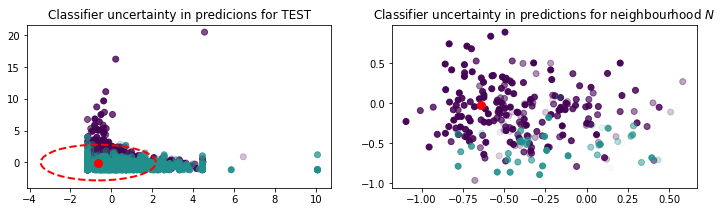

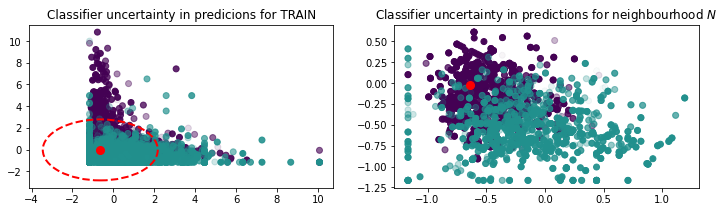

Fidelity  with shap: 0.6495726495726495
f_9<0.32146312296390533 and f_9>=-0.23029173910617828 and f_11<-0.39697059988975525 and f_12>=0.28891198337078094 and f_0<-0.10694513469934464 and f_14<-0.1787041276693344
f_9<0.32146312296390533 and f_9>=-0.23029173910617828 and f_11<-0.39697059988975525 and f_12>=0.28891198337078094 and f_0<-0.10694513469934464 and f_14<-0.1787041276693344
SHAPGAIN LUX:0.145601563227025
Fidelity  EXPLAN: 0.7391304347826088
LORE expl e = {'f_1': ['<1.1868807077407837'], 'f_9': ['>=-0.3381676822900772'], 'f_12': ['>=0.21778839826583862'], 'f_0': ['<-0.11159646511077881'], 'f_13': ['>=-1.1319520473480225'], 'f_6': ['<1.21678227186203']}
f_1<1.1868807077407837 and f_9>=-0.3381676822900772 and f_12>=0.21778839826583862 and f_0<-0.11159646511077881 and f_13>=-1.1319520473480225 and f_6<1.21678227186203
f_1<1.1868807077407837 and f_9>=-0.3381676822900772 and f_12>=0.21778839826583862 and f_0<-0.11159646511077881 and f_13>=-1.1319520473480225 and f_6<1.21678227186203
S

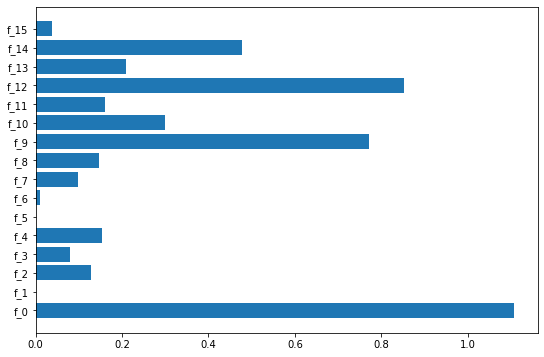

Fidelity  dectree: 0.9310344827586207
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2678924476077501 samples from train set wiuth class balance: 0.5014760147601476
--- 328.13796305656433 seconds ---
IF f_9 >=0.13686417043209076 AND f_12 >=0.2933156192302704 AND f_0 <-0.1136024035513401 AND f_0 >=-0.11944456771016121 AND f_13 >=0.15146404691040516 AND f_14 <-0.8594135046005249 THEN class = 1 # 1.0



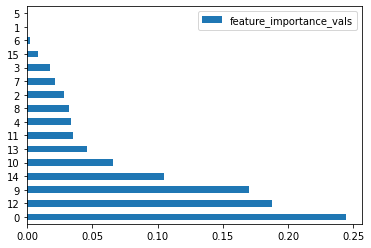

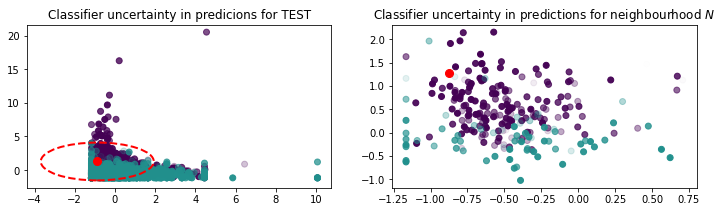

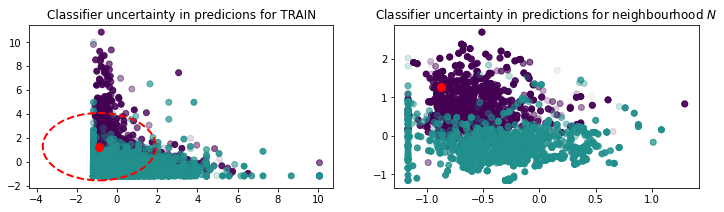

Fidelity  with shap: 0.9005847953216374
f_9>=0.13686417043209076 and f_12>=0.2933156192302704 and f_0<-0.1136024035513401 and f_0>=-0.11944456771016121 and f_13>=0.15146404691040516 and f_14<-0.8594135046005249
f_9>=0.13686417043209076 and f_12>=0.2933156192302704 and f_0<-0.1136024035513401 and f_0>=-0.11944456771016121 and f_13>=0.15146404691040516 and f_14<-0.8594135046005249
SHAPGAIN LUX:0.1507575039154863
Fidelity  EXPLAN: 0.9325842696629215
LORE expl e = {'f_13': ['>=-0.6732227802276611'], 'f_0': ['<-0.11412479355931282'], 'f_9': ['>=1.1652783751487732']}
f_13>=-0.6732227802276611 and f_0<-0.11412479355931282 and f_9>=1.1652783751487732
f_13>=-0.6732227802276611 and f_0<-0.11412479355931282 and f_9>=1.1652783751487732
SHAPGAIN explan:0.15349345002156342
Fidelity  LORE: 0.5934065934065934
LORE expl e = {'f_4': ['<0.19321101158857346'], 'f_8': ['<-0.20040348917245865'], 'f_11': ['<0.5907711684703827', '>=-0.4035901725292206'], 'f_9': ['>=0.6731577515602112'], 'f_2': ['<0.6453796923

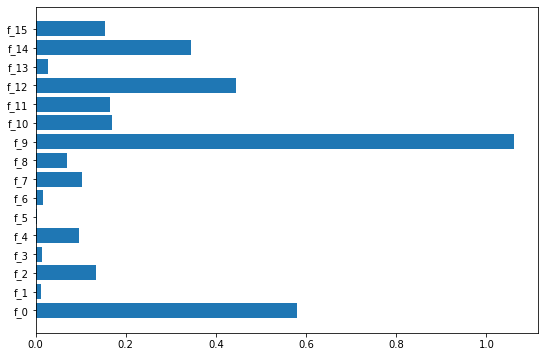

Fidelity  dectree: 0.9468599033816425
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2775800711743772 samples from train set wiuth class balance: 0.49893162393162394
--- 401.9867277145386 seconds ---
IF f_4 >=-0.11203824728727341 AND f_9 <-0.2610780894756317 AND f_10 >=-0.5276789665222168 AND f_14 >=-0.9408906400203705 THEN class = 0 # 1.0



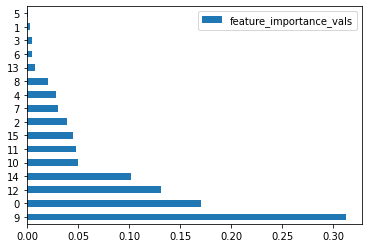

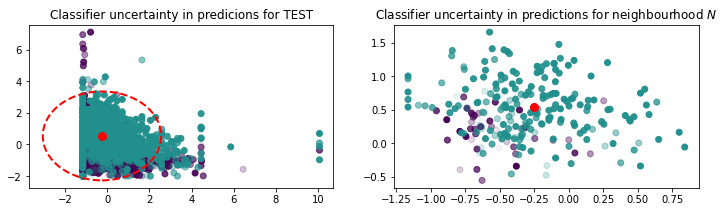

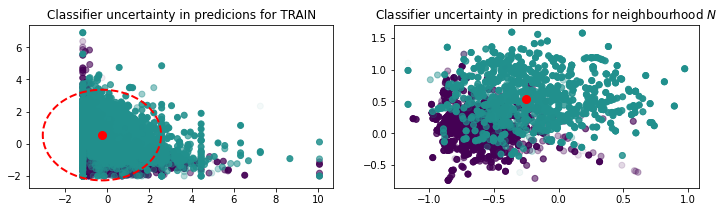

Fidelity  with shap: 0.9388753056234719
f_4>=-0.11203824728727341 and f_9<-0.2610780894756317 and f_10>=-0.5276789665222168 and f_14>=-0.9408906400203705
f_4>=-0.11203824728727341 and f_9<-0.2610780894756317 and f_10>=-0.5276789665222168 and f_14>=-0.9408906400203705
SHAPGAIN LUX:0.12306932463228917
Fidelity  EXPLAN: 0.923076923076923
LORE expl e = {'f_10': ['>=-0.6496389508247375'], 'f_9': ['<-0.4001510292291641'], 'f_3': ['<2.373427629470825']}
f_10>=-0.6496389508247375 and f_9<-0.4001510292291641 and f_3<2.373427629470825
f_10>=-0.6496389508247375 and f_9<-0.4001510292291641 and f_3<2.373427629470825
SHAPGAIN explan:0.12071206874566537
Fidelity  LORE: 0.9199999999999999
LORE expl e = {'f_13': ['>=-0.06946472451090813'], 'f_7': ['<2.1567429304122925'], 'f_9': ['<0.27939721941947937']}
Ats lore: ['f_13', 'f_7', 'f_9']
f_13>=-0.06946472451090813 and f_7<2.1567429304122925 and f_9<0.27939721941947937
f_13>=-0.06946472451090813 and f_7<2.1567429304122925 and f_9<0.27939721941947937
SHAPG

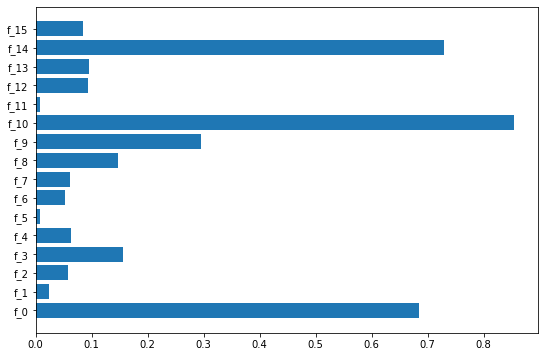

Fidelity  dectree: 0.8899082568807339
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2172795571372084 samples from train set wiuth class balance: 0.5063694267515924
--- 307.1019797325134 seconds ---
IF f_9 <0.1716528683900833 AND f_9 >= -0.2742603956705103 * f_10+0.6879229291375654 AND f_0 >=-0.11553816869854927 AND f_0 >= 0.11085651231437646 * f_12+-0.14045009995684601 AND f_13 >=0.1581703945994377 AND f_10 <3.8702428340911865 AND f_14 <-0.4066053479909897 THEN class = 1 # 1.0



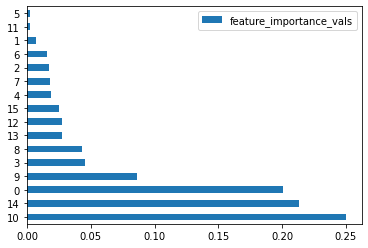

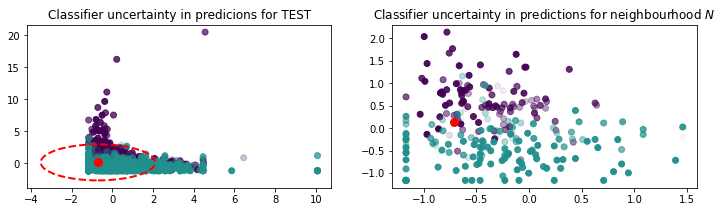

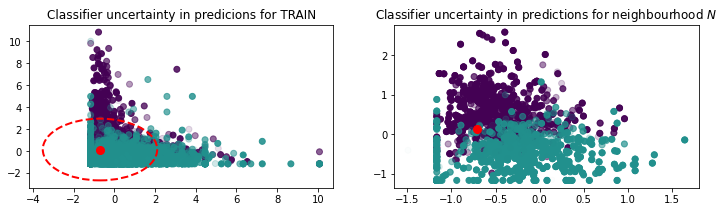

Fidelity  with shap: 0.8930232558139536
f_9<0.1716528683900833 and f_9>= -0.2742603956705103 * f_10+0.6879229291375654 and f_0>=-0.11553816869854927 and f_0>= 0.11085651231437646 * f_12+-0.14045009995684601 and f_13>=0.1581703945994377 and f_10<3.8702428340911865 and f_14<-0.4066053479909897
f_9<0.1716528683900833 and f_9>= -0.2742603956705103 * f_10+0.6879229291375654 and f_0>=-0.11553816869854927 and f_0>= 0.11085651231437646 * f_12+-0.14045009995684601 and f_13>=0.1581703945994377 and f_10<3.8702428340911865 and f_14<-0.4066053479909897
SHAPGAIN LUX:0.15567748311743457
Fidelity  EXPLAN: 0.8518518518518519
LORE expl e = {'f_4': ['<0.6470041573047638'], 'f_9': ['<0.3275892585515976', '>=-0.08877559006214142'], 'f_12': ['<0.3101511001586914'], 'f_0': ['>=-0.11157166957855225'], 'f_14': ['<-0.22162192314863205']}
f_4<0.6470041573047638 and f_9<0.3275892585515976 and f_9>=-0.08877559006214142 and f_12<0.3101511001586914 and f_0>=-0.11157166957855225 and f_14<-0.22162192314863205
f_4<0.64

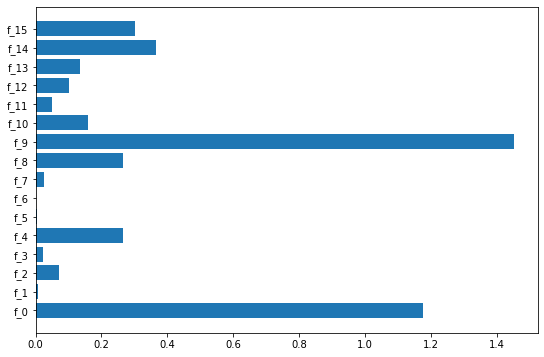

Fidelity  dectree: 0.9813333333333333
Lux ablation
Lux failed...
Lux failed...
Lux failed...
Lux w shap
In fact using: 0.2957690786872281 samples from train set wiuth class balance: 0.49966577540106955


In [ ]:
import time
nac_data  = []
fid_data = []
imp_fid_data=[]
features_data = []
stability_data = []
hits = []
confidences =[]
times=[]
rules = []
rule_coverages = []
rule_coverages_nn = []
rule_local_fid_data_nn = []
rule_local_fid_data = []
explanation_length = []

rs=42
init_fraction=0.2
directory = './data/numerical_only/balanced'
#directory = './data/num_and_cat/balanced'
up=True
depth = 2
SAMPLE_SIZE=100
show=False
ismpl=True
oblique=True
synthetic = False
density_sampling=False#True
radius_sampling=False#True
oversampling=True
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_NEAREST
categorical_indicator=None
node_size_limit = 2
n_jobs=-1
min_generate_samples=0.3

UId3.PARALLEL_ENTRY_FACTOR = 1000
nf = 4
SYNTH_BREAK=12
progress = []
for num_and_cat in  os.listdir(directory):
    progress.append(num_and_cat)
    rules_temp = []
    clf_basic  =GradientBoostingClassifier()#MLPClassifier()#GradientBoostingClassifier()#RandomForestClassifier(random_state=rs,n_jobs=-1)
    #clf = svm.SVC(probability=True,random_state=rs)
    if directory =='./data/numerical_only/balanced':
        (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
        features = [f'f_{i}' for i in range(0,data.shape[1])]
        categorical_indicator=[False]*len(features)
        clf = clf_basic
    elif directory =='./data/num_and_cat/balanced':
        (data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
        features = [f'f_{i}' for i in range(0,data.shape[1])]
        density_sampling=False
        categories_data = data[:,categorical_indicator]
        categories=[np.unique(categories_data[:,i]).astype(int) for i in np.arange(categories_data.shape[1])]
        clf = CategoricalWrapper(clf_basic, None, categorical_indicator, features, categories=categories)
        
    target = 'class'
    
    if synthetic: 
        if nf > SYNTH_BREAK:
            break
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=250*int(nf), n_features=nf+4, 
                                              n_informative=int(nf/2), n_redundant=int(nf/4), n_repeated=0, n_clusters_per_class=int(nf/2),
                                              n_classes=2)
        features = [f'f_{i}' for i in range(0,X.shape[1])]
        categorical_indicator=[False]*len(features)
        df = pd.DataFrame(X, columns=features)
        df[target] = y
        num_and_cat = f'n_samples={250*int(nf)};n_features={nf+4};n_informative={int(nf/2)};n_redundant={int(nf/4)};n_classes={2};n_clusters={int(nf/2)}'
        directory='synthetic'
    else:
        continuous_indicator = np.logical_not(categorical_indicator)

        df = pd.DataFrame(data,columns=features,dtype=float)
        sc = StandardScaler()
        df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
        df[target] = y
    
    nf+=1
    depth = len(features)+4

    if num_and_cat in ['data_Higgs','data_covertype','data_MiniBooNE']:
        continue
    if len(df) >6000:
        density_sampling=False
        fraction = 1000.0/len(df)
    else:
        density_sampling=True
        fraction = init_fraction
        
    print(num_and_cat)
    if df[target].nunique() > 2:
        average="micro"
    else:
        average="binary"
    
    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
    print(f'Train size: {len(train)}')
    
    processed_samples = 0
    for explain_instance in test[features].sample(SAMPLE_SIZE,random_state=rs).values:
        explain_instance=np.array(explain_instance).reshape(1,-1)
        #explain_instance = test[features].sample(1).values#.astype('f8')    
         
        with open(f'./results/progress.txt', 'w') as fp:
            fp.write('\n'.join(progress))
            fp.write(f'Processed {processed_samples}/100')
        processed_samples +=1
        
        instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
        print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')
    
        # distances = sklearn.metrics.pairwise_distances(test[features], explain_instance)
        # pd.DataFrame(distances).hist()
        # plt.show()
        # _,borders = np.histogram(distances)
        # idxs,_ = np.where(distances<=borders[2])
        # dfneigh = test.iloc[idxs]
        # print(f'Neighbourhood size: {len(dfneigh)}')
        
        n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
        nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
        nn.fit(test[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh= test.iloc[ids_c.ravel()]
        
        nn.fit(train[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh_tr= train.iloc[ids_c.ravel()]
        
        
        start_time = time.time()
        ##############for testing dectree on the bbox sample################
        lux = LUX(predict_proba = clf.predict_proba, classifier=clf,neighborhood_size=fraction,max_depth=depth,  min_samples=5,
                  oversampling_strategy='both',
                  node_size_limit = node_size_limit, grow_confidence_threshold = 0,min_generate_samples=min_generate_samples)
        X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                                  X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                  use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                                 representative=representative,density_sampling=density_sampling,n_jobs=-1)
        print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')
        ###################################################################
        time_lux_gen = time.time() - start_time
        #shap on this sample
        #append pint as a first element and plot force plot
        X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        
    
            
        try:
            explainer = shap.Explainer(clf,X_shap)
            if hasattr(explainer, "shap_values"):
                shap_values = explainer.shap_values(X_shap,check_additivity=False)
            else:
                shap_values = explainer(X_shap).values
                shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
            if hasattr(explainer, "expected_value"):
                expected_values = explainer.expected_value
            else:
                expected_values=[np.mean(v) for v in shap_values]
        except TypeError:
            explainer = shap.Explainer(clf.predict_proba, X_shap)
            shap_values = explainer(X_shap).values
            shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
            expected_values=[np.mean(v) for v in shap_values]


        if type(shap_values) is not list:
            shap_values = [-shap_values, shap_values]
            expected_values=[np.mean(v) for v in shap_values]

        
        plt.figure(figsize=(9,6))
        plt.barh(features ,np.abs(shap_values).mean(0)[0])
        plt.show()
        vals = np.abs(shap_values).mean(0)[0]/np.abs(shap_values).mean(0)[0].sum()
        rsv = [sv[1:] for sv in shap_values]
            
        
            
        
        #take N most relevant features and focus only on these when building explanations

        feature_importance = pd.DataFrame(list(zip(features,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        shapfeatures = feature_importance.head(n=10) ## see if features used in predicting the explain instance are among the top oN of shap-returned values (LOCALLY) -- do the same with global SHAP values

        data = Data.parse_dataframe(dfneigh[features+[target]],categorical=categorical_indicator)
        clf_dtree = DecisionTreeClassifier(random_state=rs,max_depth=depth,criterion='entropy')
        clf_dtree.fit(train[features],clf.predict(train[features]))
        feature_importance.plot(kind='barh')
        if show:
            graph = Source(tree.export_graphviz(clf_dtree, out_file=None
               , feature_names=features, 
                                                #class_names=['0', '1'] ,
                filled = True,max_depth=depth))
            display(SVG(graph.pipe(format='svg')))
            
        pos_label = clf.predict(explain_instance)[0]

        dectree_score =  accuracy_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]))
        dectree_score_prec =  precision_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        dectree_score_rec =  recall_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        dectree_score_f1 =  f1_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        print(f'Fidelity  dectree: {dectree_score_f1}')
        dectree_score_acc =  accuracy_score(clf_dtree.predict(dfneigh[features]),dfneigh[target])
        
        #dtree_elen = clf_dtree.decision_path(explain_instance).shape[1]
        
        nodes = np.where(1==clf_dtree.decision_path(explain_instance).todense())[1]
        features_idxs = clf_dtree.tree_.feature[nodes][:-1]
        dtree_ats = list(set(([features[i] for i in features_idxs])))
        dtree_elen = len(dtree_ats)
        
        importance_gain_dtree = shapfeatures[shapfeatures['col_name'].isin(dtree_ats)]['feature_importance_vals'].sum()/len(dtree_ats)
        
        hit_dectree = (clf_dtree.predict(explain_instance)==clf.predict(explain_instance))
        
        ########################################################## ###### #######################################################
        ########################################################## LUX ABLATION #################################################

        print('Lux ablation')
        try:
            x=12/0
            start_time = time.time()
            #explain xgboost without proba, 
            def noproba_predictor(x):
                preds = clf.predict_proba(x)
                hot = np.argmax(preds,axis=1)
                result = np.zeros(preds.shape)
                for i in range(0,len(result)):
                    result[i,hot[i]] = 1
                return result
            lux = LUX(predict_proba = lambda x: noproba_predictor(x), neighborhood_size=fraction,max_depth=depth,  
                      node_size_limit =node_size_limit, grow_confidence_threshold = 0)
            #lux.attributes_names=X_train_sample.columns
            #This is commented out for the computational efficiency of the benchmark
            lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=False,oversampling=False,representative=representative,
                    radius_sampling=False, inverse_sampling=False ,density_sampling=False, n_jobs=-1,
                   uncertain_entropy_evaluator=uncertain_entropy_evaluator,prune=True)


            time_lux_ablation = time.time() - start_time+time_lux_gen
            print("--- %s seconds ---" % (time_lux_ablation))
            #calculate decision tree score over this dataset
            if show:
                lux.uid3.tree.save_dot('tree.dot')
                gvz=graphviz.Source.from_file('tree.dot')
                display(gvz)


            f1,f2=get_plot_features(lux,explain_instance,all_features = features)
            plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
            plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
            if synthetic and X_train_sample.shape[1] == 2:
                decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)

                print('Tree was cut to the ground...')

            predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
            ac_score_ablation = accuracy_score(predictions, clf.predict(dfneigh[features]))
            prec_score_ablation = precision_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            rec_score_ablation = recall_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            f1_score_ablation = f1_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            print(f'Fidelity  no proba: {f1_score_ablation}')
            ac_score_ablation_acc =  accuracy_score(dfneigh[target],predictions)
            hit_lux_ablation = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_ablation = justification_dict['rule']
            ablation_lux_elen = len(justification_dict['rule'].keys())

            cov_ablation, acc_ablation, prec_ablation,rec_ablation,f1_ablation = coverage_precision(rule_lux_ablation, test, features, categorical_indicator, 
                                                                                                    justification_dict['prediction'], class_label='class', average=average,
                                                                                                    lux_format=True)
            cov_ablation_nn, acc_ablation_nn, prec_ablation_nn,rec_ablation_nn,f1_ablation_nn = coverage_precision(rule_lux_ablation, dfneigh, features, categorical_indicator, 
                                                                                                    justification_dict['prediction'], class_label='class', average=average,
                                                                                                    lux_format=True)


            justification = lux.justify(explain_instance)[0]
            lux_conf_ablation = justification.split("#")[1]
            ats_ablation = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
            importance_gain_ablation = shapfeatures[shapfeatures['col_name'].isin(ats_ablation)]['feature_importance_vals'].sum()/len(ats_ablation)
        except:
            print('Lux failed...')
            importance_gain_ablation=0
            ats_ablation=[]
            lux_conf_ablation=0
            cov_ablation_nn=acc_ablation_nn=prec_ablation_nn=rec_ablation_nn=f1_ablation_nn =cov_ablation=acc_ablation=prec_ablation=rec_ablation=f1_ablation =0
            time_lux_ablation=ac_score_ablation=prec_score_ablation=rec_score_ablation=f1_score_ablation=ac_score_ablation_acc=hit_lux_ablation=0
            ablation_lux_elen=0
            rule_lux_ablation={}
            
        ########################################################## ###### #######################################################
        ########################################################## LUX ######################################################

        try:
            x=12/0
            print('Lux ww proba')
            start_time = time.time()
            #explain xgboost without proba, 
            def noproba_predictor(x):
                preds = clf.predict_proba(x)
                hot = np.argmax(preds,axis=1)
                result = np.zeros(preds.shape)
                for i in range(0,len(result)):
                    result[i,hot[i]] = 1
                return result
            lux = LUX(predict_proba = lambda x: noproba_predictor(x), neighborhood_size=fraction,max_depth=depth,  node_size_limit = node_size_limit, grow_confidence_threshold = 0)
            lux.attributes_names=X_train_sample.columns
            #This is commented out for the computational efficiency of the benchmark
            # lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=False,oversampling=False,representative=representative,
            #         radius_sampling=False, inverse_sampling=False ,density_sampling=False, n_jobs=-1,
            #        uncertain_entropy_evaluator=uncertain_entropy_evaluator)

            ## To make it faster, not repeat neighbourhood selection step every time:
            y_train_sample = lux.predict_proba(X_train_sample)
            #limit features here
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)

            time_lux_pure = time.time() - start_time+time_lux_gen
            print("--- %s seconds ---" % (time_lux_pure))
            #calculate decision tree score over this dataset
            if show:
                lux.uid3.tree.save_dot('tree.dot')
                gvz=graphviz.Source.from_file('tree.dot')
                display(gvz)

            f1,f2=get_plot_features(lux,explain_instance,all_features = features)
            plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
            plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
            if synthetic and X_train_sample.shape[1] == 2:
                decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)

            predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
            ac_score_pure = accuracy_score(predictions, clf.predict(dfneigh[features]))
            prec_score_pure = precision_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            rec_score_pure = recall_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            f1_score_pure = f1_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            print(f'Fidelity  no proba: {f1_score_pure}')
            ac_score_pure_acc =  accuracy_score(dfneigh[target],predictions)
            hit_lux_pure = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_pure = justification_dict['rule']
            pure_lux_elen = len(justification_dict['rule'].keys())

            cov_pure, acc_pure, prec_pure, rec_pure, f1_pure = coverage_precision(rule_lux_pure, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_pure_nn, acc_pure_nn, prec_pure_nn, rec_pure_nn, f1_pure_nn = coverage_precision(rule_lux_pure, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            justification = lux.justify(explain_instance)[0]
            lux_conf_pure = justification.split("#")[1]
            ats_no_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
            importance_gain_noproba = shapfeatures[shapfeatures['col_name'].isin(ats_no_proba)]['feature_importance_vals'].sum()/len(ats_no_proba)
        except:
            print('Lux failed...')
            importance_gain_noproba=0
            ats_no_proba=[]
            lux_conf_pure=0
            cov_pure= acc_pure= prec_pure= rec_pure=f1_pure  =0
            cov_pure_nn= acc_pure_nn= prec_pure_nn= rec_pure_nn=f1_pure_nn  =0
            time_lux_pure=ac_score_pure=prec_score_pure=rec_score_pure=f1_score_pure=ac_score_pure_acc=hit_lux_pure=0
            pure_lux_elen=0
            rule_lux_pure={}
        ########################################################## ###### #######################################################
        ########################################################## LUX + PROBA #######################################################
        try:
            x=12/0
            print('Lux w proba')
            start_time = time.time()
            #with proba, 
            lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = node_size_limit, grow_confidence_threshold = 0 )
            lux.attributes_names=X_train_sample.columns
            #lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up, 
            #        uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,representative=representative,
            #        radius_sampling=radius_sampling,inverse_sampling= ismpl,density_sampling=density_sampling, n_jobs=-1)

            ## To make it faster, not repeat neighbourhood selection step every time:
            y_train_sample = lux.predict_proba(X_train_sample)
            #limit features here
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)

            time_lux_proba = time.time() - start_time+time_lux_gen
            print("--- %s seconds ---" % (time_lux_proba))
            if show:
                lux.uid3.tree.save_dot('tree.dot')
                gvz=graphviz.Source.from_file('tree.dot')
                display(gvz)

            f1,f2=get_plot_features(lux,explain_instance,all_features = features)
            plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
            plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
           # decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)


            predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
            ac_score_proba = accuracy_score(predictions, clf.predict(dfneigh[features]))
            prec_score_proba = precision_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            rec_score_proba = recall_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            f1_score_proba = f1_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            hit_lux_proba = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])
            print(f'Fidelity  with proba: {f1_score_proba}')
            ac_score_proba_acc =  accuracy_score(dfneigh[target],predictions)


            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_proba = justification_dict['rule']
            proba_lux_elen = len(justification_dict['rule'].keys())

            cov_proba, acc_proba, prec_proba, rec_proba, f1_proba = coverage_precision(rule_lux_proba, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_proba_nn, acc_proba_nn, prec_proba_nn, rec_proba_nn, f1_proba_nn = coverage_precision(rule_lux_proba, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            justification = lux.justify(explain_instance)[0]
            lux_conf_proba = justification.split("#")[1]
            ats_with_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
            importance_gain_with_proba = shapfeatures[shapfeatures['col_name'].isin(ats_with_proba)]['feature_importance_vals'].sum()/len(ats_with_proba)
        except:
            print('Lux failed...')
            importance_gain_with_proba=0
            ats_with_proba=[]
            lux_conf_proba=0
            cov_proba= acc_proba= prec_proba= rec_proba=f1_proba  =0
            cov_proba_nn= acc_proba_nn= prec_proba_nn= rec_proba_nn=f1_proba_nn  =0
            time_lux_proba=ac_score_proba=prec_score_proba=rec_score_proba=f1_score_proba=ac_score_proba_acc=hit_lux_proba=0
            proba_lux_elen=0
            rule_lux_proba={}
        
        ########################################################## ###### #######################################################
        ########################################################## LUSX + SHAP #######################################################
        if True:#try:
            print('Lux w shap')
            start_time = time.time()
            lux = LUX(classifier = clf,predict_proba = clf.predict_proba, 
                      neighborhood_size=fraction,max_depth=depth,  node_size_limit = node_size_limit, grow_confidence_threshold = 0 )
            lux.attributes_names=X_train_sample.columns
            # lux.fit(train[features], train[target], 
            #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
            #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
            #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )

            ## To make it faster, not repeat neighbourhood selection step every time:
            #y_train_sample = lux.predict_proba(X_train_sample)
            
            #TODO: remove samples of the same class as instance2explain and replace with samples from LORE
            ###############################
            ###############################
            ###############################
#             myds = prepare_ds(train,discrete=categorical_indicator)
#             instance2explain = explain_instance.ravel()
#             X_explain = np.concatenate(([instance2explain], myds['X']))
#             Zdf,Z = generate_lore_dataset(0, X2E=X_explain, dataset=myds, blackbox=clf,
#                         ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
#                         discrete_use_probabilities=True,
#                         continuous_function_estimation=False)
            
#             #combined zdf with X_train_sample
#             zpred = clf.predict(Zdf[features])
#             lpred = clf.predict(X_train_sample)
#             #pos_label is the label of instance to explain
#             Xtsp = X_train_sample[lpred!=pos_label]
#             Xtspp = Zdf[zpred==pos_label][features]
            
#             X_train_sample = pd.concat((Xtsp, Xtspp))
            
            ###############################
            ###############################
            ###############################
            
            y_train_sample_proba = lux.predict_proba(X_train_sample)
            hot = np.argmax(y_train_sample_proba,axis=1)
            y_train_sample = np.zeros(y_train_sample_proba.shape)
            for i in range(0,len(y_train_sample)):
                y_train_sample[i,hot[i]] = 1
            #limit features here
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=False,
                                        depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1,
                                        n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)


            time_lux_shap = time.time() - start_time+time_lux_gen
            print("--- %s seconds ---" % (time_lux_shap))

            if show:
                lux.uid3.tree.save_dot('tree.dot')
                gvz=graphviz.Source.from_file('tree.dot')
                display(gvz)
            f1,f2=get_plot_features(lux,explain_instance,all_features = features)
            plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
            plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
            #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)


            predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
            ac_score_shap = accuracy_score(clf.predict(dfneigh[features]),predictions)
            prec_score_shap = precision_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            rec_score_shap = recall_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            f1_score_shap = f1_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            hit_lux_shap = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])
            print(f'Fidelity  with shap: {f1_score_shap}')
            ac_score_shap_acc = accuracy_score(dfneigh[target],predictions)

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_shap = justification_dict['rule']
            shap_lux_elen = len(justification_dict['rule'].keys())

            cov_shap, acc_shap, prec_shap, rec_shap, f1_shap = coverage_precision(rule_lux_shap, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_shap_nn, acc_shap_nn, prec_shap_nn, rec_shap_nn, f1_shap_nn = coverage_precision(rule_lux_shap, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            justification = lux.justify(explain_instance)[0]
            lux_conf_shap = justification.split("#")[1]
            ats_shap= list(justification_dict['rule'].keys())
            importance_gain_shap = shapfeatures[shapfeatures['col_name'].isin(ats_shap)]['feature_importance_vals'].sum()/len(ats_shap)
            print(f'SHAPGAIN LUX:{importance_gain_shap}')
        # except:
        #     print('Lux failed...')
        #     importance_gain_shap=0
        #     ats_shap=[]
        #     lux_conf_shap=0
        #     cov_shap= acc_shap= prec_shap= rec_shap= f1_shap  =0
        #     cov_shap_nn= acc_shap_nn= prec_shap_nn= rec_shap_nn= f1_shap_nn  =0
        #     time_lux_shap=ac_score_shap=prec_score_shap=rec_score_shap=f1_score_shap=ac_score_shap_acc=hit_lux_shap=0
        #     shap_lux_elen=0
        #     rule_lux_shap={}
        
        ########################################################## ###### #######################################################
        ########################################################## EXPLAN #######################################################
        #X_train_sample['class'] = np.argmax(y_train_sample,axis=1)
        try:
            start_time = time.time()
            myds = prepare_ds(train,discrete=categorical_indicator)
            #myds = prepare_ds(dfneigh_tr,discrete=categorical_indicator)
            X, y = myds['X'], myds['y']
            instance2explain = explain_instance.ravel()

            # EXPLAN hyper-parameters
            N_samples = 3000#n_neighbors
            tau = 250#int(n_neighbors)/len(np.unique(df[target])

            # Explaining instance x using EXPLAN
            # exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
            #                                            clf,
            #                                            myds,
            #                                            N_samples=N_samples,
            #                                            tau=tau,depth=depth)

            dense_samples = DataGeneration(instance2explain, clf, myds, 3000)
            # Representative data selection step
            representative_samples = DataSelection(instance2explain, clf, dense_samples, 250)
            # Data balancing step
            neighborhood_data = DataBalancing(clf, representative_samples, myds)

            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = clf.predict(Ndf[features])

            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs)

            time_explan = time.time() - start_time

            #explan_y=pyyadt.predict(info_EXPLAN['C'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
            explan_y=predict_lux(uid3,dfneigh[features])
            ac_score_explan = accuracy_score(clf.predict(dfneigh[features]),explan_y)
            prec_score_explan = precision_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            rec_score_explan = recall_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            f1_score_explan = f1_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)

            print(f'Fidelity  EXPLAN: {f1_score_explan}')
            ac_score_explan_acc = accuracy_score(dfneigh[target],explan_y)
        

            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            

            rule_EXPLAN = justification_dict['rule']
            explan_elen = len(justification_dict['rule'].keys())
            hit_explan = clf.predict(explain_instance)==int(justification_dict['prediction'])

            print('LORE expl e = %s' % rule_EXPLAN)


            cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_EXPLAN_nn, acc_EXPLAN_nn, prec_EXPLAN_nn, rec_EXPLAN_nn, f1_EXPLAN_nn = coverage_precision(rule_EXPLAN, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')


            ats_explan = list(justification_dict['rule'].keys())
            explan_elen = len(ats_explan)
            importance_gain_explan = shapfeatures[shapfeatures['col_name'].isin(ats_explan)]['feature_importance_vals'].sum()/len(ats_explan)
            print(f'SHAPGAIN explan:{importance_gain_explan}')
        except:
            cov_EXPLAN=acc_EXPLAN=prec_EXPLAN=rec_EXPLAN=f1_EXPLAN=explan_elen = importance_gain_explan = prec_score_explan =rec_score_explan=f1_score_explan=ac_score_lore_explan=time_explan = np.nan
            cov_EXPLAN_nn= acc_EXPLAN_nn= prec_EXPLAN_nn= rec_EXPLAN_nn= f1_EXPLAN_nn =np.nan
            rule_EXPLAN={}
            ats_explan=[]
        
        
        ########################################################## ###### #######################################################
        ########################################################## LORE #########################################################
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            # exp_LORE, info_LORE = lore.explain(0, X_explain,
            #                                    myds, clf,
            #                                    ng_function=genetic_neighborhood,
            #                                    discrete_use_probabilities=True,
            #                                    continuous_function_estimation=False,
            #                                    returns_infos=True, path='./EXPLAN/yadt/',
            #                                    sep=';', log=True, depth=depth)
            
            Zdf,Z = generate_lore_dataset(0, X2E=X_explain, dataset=myds, blackbox=clf,
                        ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
                        discrete_use_probabilities=True,
                        continuous_function_estimation=False)
            
            datalore = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(datalore,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs)
            #rnum_lore = len(uid3.tree.to_dict())
            #crgen,mg,numfan,prop = coverage_rules(uid3.tree, Zdf, train,features=features)
         
            time_lore = time.time() - start_time
            #lore_y=pyyadt.predict(info_LORE['dt'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
            
            lore_y = predict_lux(uid3,dfneigh[features])
            ac_score_lore = accuracy_score( clf.predict(dfneigh[features]),lore_y)

            prec_score_lore = precision_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            rec_score_lore = recall_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            f1_score_lore = f1_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            
            hit_lore = (clf.predict(explain_instance)==lore_y[0])
            print(f'Fidelity  LORE: {f1_score_lore}')
            ac_score_lore_acc = accuracy_score(dfneigh[target],lore_y)

            
            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_LORE = justification_dict['rule']
            lore_elen = len(justification_dict['rule'].keys())
            
            print('LORE expl e = %s' % rule_LORE)
                
            ats_lore= list(justification_dict['rule'].keys())
            print(f'Ats lore: {ats_lore}')
            cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_LORE_nn, acc_LORE_nn, prec_LORE_nn, rec_LORE_nn, f1_LORE_nn = coverage_precision(rule_LORE, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            
            importance_gain_lore = shapfeatures[shapfeatures['col_name'].isin(ats_lore)]['feature_importance_vals'].sum()/len(ats_lore)
            print(f'SHAPGAIN lore:{importance_gain_lore}')
        except:
            cov_LORE=acc_LORE=prec_LORE=rec_LORE=f1_LORE =lore_elen = importance_gain_lore = prec_score_lore =rec_score_lore=f1_score_lore=ac_score_lore_acc=time_lore=np.nan
            cov_LORE_nn= acc_LORE_nn= prec_LORE_nn= rec_LORE_nn= f1_LORE_nn = np.nan
            rule_LORE={}
            ats_lore=[]
            hit_lore=0
            print('LORE failed...')

        
        ########################################################## ###### #######################################################
        ########################################################## ANCHOR #######################################################
        
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            #anchor_explainer = fit_anchor(myds, train[features], test[features], train[target], test[target], X_explain)
            anchor_explainer = fit_anchor(myds, train[features], train[features], train[target], train[target], X_explain)
            exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                        clf.predict, threshold=np.max([0.5]+[f for f in [prec_score_lore,prec_score_explan, prec_score_shap, prec_score_proba, prec_score_pure] if f is not np.nan]))

            time_anchor= time.time() - start_time
            anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
            ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]
            importance_gain_anchor = shapfeatures[shapfeatures['col_name'].isin(ats_anchor)]['feature_importance_vals'].sum()/len(ats_anchor)
            print(f'SHAPGAIN anchor:{importance_gain_anchor}')

            #fit_partial = np.where(np.all(X_explain[:, exp_Anchor.features(anch_depth)] == X_explain[0][exp_Anchor.features(anch_depth)], axis=1))[0]
            #prec_anchor =  (np.mean(clf.predict(X_explain[fit_partial]) == clf.predict(X_explain[0].reshape(1, -1))))
            #cov_anchor = exp_Anchor.exp_map['coverage'][anch_depth]
            #print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_explain.shape[0])))

            rule_Anchor_full = anchor2arule(exp_Anchor)
            rule_Anchor={}
            for i,v in rule_Anchor_full.items():
                if i in ats_anchor[:anch_depth+1]:
                    rule_Anchor[i]=[v]

            dfXExplain = build_df2explain(clf, X_explain, myds)
            cv = get_covered(rule_Anchor_full, dfXExplain.to_dict('records'), myds)
            if len(cv) != 0:
                hit_anchor = (cv[0] == 0)
            else:
                hit_anchor=0
            rule_Anchor = split_rule_conditions(rule_Anchor)
            print(f'Anchor explanation: {rule_Anchor}')
            anchor_elen = len(ats_anchor)
            cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, categorical_indicator, pos_label, class_label='class')
            cov_anchor_nn, acc_anchor_nn, prec_anchor_nn, rec_anchor_nn, f1_anchor_nn = coverage_precision(rule_Anchor, dfneigh, features, categorical_indicator, pos_label, class_label='class')
        except:
            print('Anchor failed...')
            cov_anchor=acc_anchor=prec_anchor=rec_anchor= f1_anchor=anchor_elen = hit_anchor=importance_gain_anchor=time_anchor=np.nan
            cov_anchor_nn= acc_anchor_nn= prec_anchor_nn= rec_anchor_nn= f1_anchor_n=np.nan
            rule_Anchor={}
    

        ########################################################## ###### #######################################################
        ########################################################## ###### #######################################################
        
        
        rules.append([num_and_cat,directory,explain_instance,rule_lux_ablation, rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])
        rules_temp.append([explain_instance,clf.predict(explain_instance)[0],rule_lux_ablation,rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])

        features_data.append([num_and_cat,directory,shapfeatures['col_name'].values,ats_ablation,ats_no_proba,ats_with_proba,ats_shap,ats_explan])
        
        times.append([num_and_cat,directory,time_lux_ablation,time_lux_pure, time_lux_proba, time_lux_shap, time_explan, time_lore, time_anchor])
        
        imp_fid_data.append([num_and_cat,directory,importance_gain_dtree,importance_gain_ablation,importance_gain_noproba, importance_gain_with_proba, importance_gain_shap, importance_gain_explan,importance_gain_lore,importance_gain_anchor])
        
        hits.append([num_and_cat,directory,model_score,instance_certainty_clf,hit_dectree, hit_lux_ablation,hit_lux_pure, hit_lux_proba, hit_lux_shap, hit_explan, hit_lore, hit_anchor])
        
        confidences.append([num_and_cat,directory,model_score,instance_certainty_clf,lux_conf_ablation,lux_conf_pure, lux_conf_proba, lux_conf_shap])
        
        fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                         dectree_score,ac_score_ablation,ac_score_pure,ac_score_proba,ac_score_shap,ac_score_explan,ac_score_lore,
                        dectree_score_prec,prec_score_ablation,prec_score_pure,prec_score_proba,prec_score_shap,prec_score_explan,prec_score_lore, 
                        dectree_score_rec,rec_score_ablation,rec_score_pure,rec_score_proba,rec_score_shap,rec_score_explan,rec_score_lore,
                        dectree_score_f1,f1_score_ablation,f1_score_pure,f1_score_proba,f1_score_shap,f1_score_explan,f1_score_lore])
        nac_data.append([num_and_cat,directory,instance_certainty_clf,ac_score_ablation_acc,ac_score_pure_acc,ac_score_proba_acc,ac_score_shap_acc, model_score, dectree_score_acc,ac_score_explan_acc,ac_score_lore_acc
                         ])
        rule_coverages.append([num_and_cat,directory,model_score,instance_certainty_clf,cov_ablation,cov_pure, cov_proba, cov_shap, cov_EXPLAN, cov_LORE, cov_anchor])
        rule_local_fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                              acc_ablation,acc_pure, acc_proba, acc_shap, acc_EXPLAN, acc_LORE, acc_anchor,
                              prec_ablation,prec_pure, prec_proba, prec_shap, prec_EXPLAN, prec_LORE, prec_anchor,
                              rec_ablation,rec_pure, rec_proba, rec_shap, rec_EXPLAN, rec_LORE, rec_anchor,
                              f1_ablation,f1_pure, f1_proba, f1_shap, f1_EXPLAN, f1_LORE, f1_anchor
                             ])
        
        rule_coverages_nn.append([num_and_cat,directory,model_score,instance_certainty_clf,cov_ablation_nn,cov_pure_nn, cov_proba_nn, cov_shap_nn, cov_EXPLAN_nn, cov_LORE_nn, cov_anchor_nn])
        rule_local_fid_data_nn.append([num_and_cat,directory,model_score,instance_certainty_clf,
                              acc_ablation_nn,acc_pure_nn, acc_proba_nn, acc_shap_nn, acc_EXPLAN_nn, acc_LORE_nn, acc_anchor_nn,
                              prec_ablation_nn,prec_pure_nn, prec_proba_nn, prec_shap_nn, prec_EXPLAN_nn, prec_LORE_nn, prec_anchor_nn,
                              rec_ablation_nn,rec_pure_nn, rec_proba_nn, rec_shap_nn, rec_EXPLAN_nn, rec_LORE_nn, rec_anchor_nn,
                              f1_ablation_nn,f1_pure_nn, f1_proba_nn, f1_shap_nn, f1_EXPLAN_nn, f1_LORE_nn, f1_anchor_nn
                             ])
        
        explanation_length.append([num_and_cat,directory,model_score,instance_certainty_clf,dtree_elen, ablation_lux_elen,pure_lux_elen, proba_lux_elen, shap_lux_elen, explan_elen, lore_elen, anchor_elen])
        
    ## calculate stability here
    results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor'])
    stab_stats = [stability_stats(results_rules, rid, train, features, categorical_indicator) for rid in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']]
    stability_data.append([num_and_cat,directory]+list(np.concatenate(stab_stats)))
    
    ## save results       

In [ ]:
print('ok')

## Results visualization

In [19]:
data_prefix = './results/realx100_deep_prune_oblique_os_shap_densamp_6/'

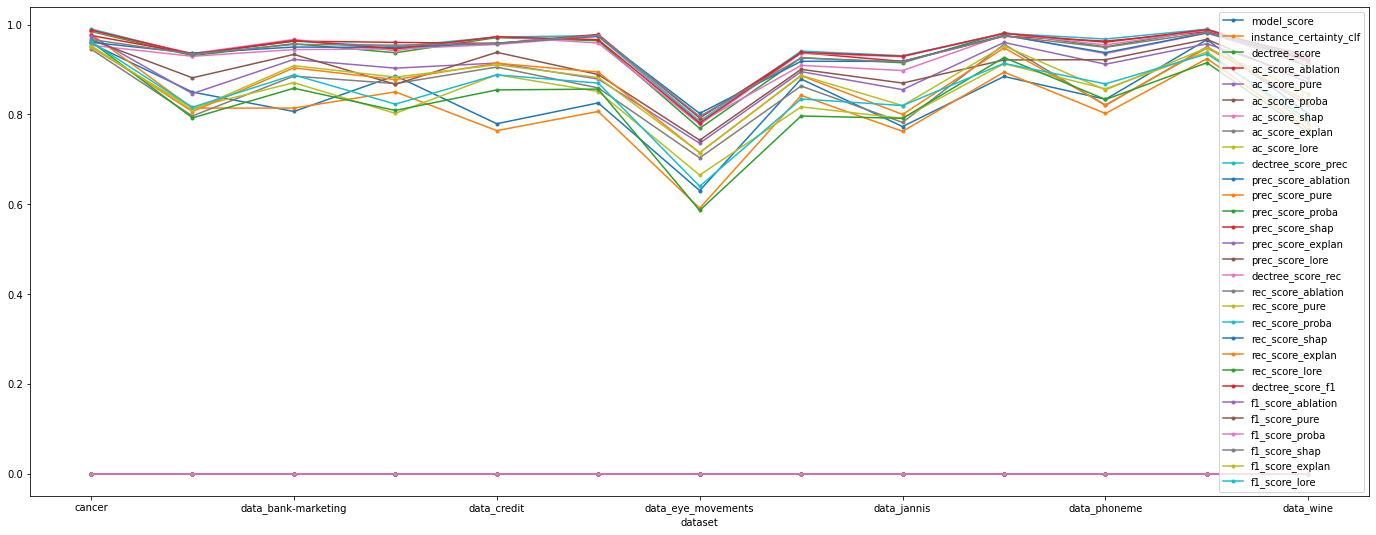

In [20]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','dectree_score',
                                             'ac_score_ablation','ac_score_pure','ac_score_proba','ac_score_shap',  'ac_score_explan','ac_score_lore',
                                             'dectree_score_prec','prec_score_ablation','prec_score_pure','prec_score_proba','prec_score_shap','prec_score_explan','prec_score_lore',
                        'dectree_score_rec','rec_score_ablation','rec_score_pure','rec_score_proba','rec_score_shap','rec_score_explan','rec_score_lore',
                        'dectree_score_f1','f1_score_ablation','f1_score_pure','f1_score_proba','f1_score_shap','f1_score_explan','f1_score_lore'])#.fillna(0)
results_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))
results_fid.to_csv(data_prefix+"synthx100_scores.csv",index=False)

In [21]:
results_fid

dataset                     num_and_cat  model_score  \
0       data_house_16H  ./data/numerical_only/balanced     0.878707   
1       data_house_16H  ./data/numerical_only/balanced     0.878707   
2       data_house_16H  ./data/numerical_only/balanced     0.878707   
3       data_house_16H  ./data/numerical_only/balanced     0.878707   
4       data_house_16H  ./data/numerical_only/balanced     0.878707   
...                ...                             ...          ...   
1202  data_electricity  ./data/numerical_only/balanced     0.825450   
1203  data_electricity  ./data/numerical_only/balanced     0.825450   
1204  data_electricity  ./data/numerical_only/balanced     0.825450   
1205  data_electricity  ./data/numerical_only/balanced     0.825450   
1206  data_electricity  ./data/numerical_only/balanced     0.825450   

      instance_certainty_clf  dectree_score  ac_score_ablation  ac_score_pure  \
0                   0.951803          0.944                  0              0   
1                   0.986286          0.892                  0              0   
2                   0.944594          0.980                  0              0   
3                   0.964985          0.984                  0              0   
4                   0.949255          0.928                  0              0   
...                      ...            ...                ...            ...   
1202                0.778950          0.944                  0              0   
1203                0.812024          0.944                  0              0   
1204                0.873242          0.988                  0              0   
1205                0.833299          0.976                  0              0   
1206                0.674825          0.900                  0              0   

      ac_score_proba  ac_score_shap  ac_score_explan  ...  rec_score_shap  \
0                  0          0.900            0.836  ...        0.917051   
1                  0          0.888            0.784  ...        0.912281   
2                  0          0.948            0.812  ...        0.954357   
3                  0          0.956            0.956  ...        0.959184   
4                  0          0.928            0.888  ...        0.928230   
...              ...            ...              ...  ...             ...   
1202               0          0.948            0.812  ...        0.939850   
1203               0          0.964            0.848  ...        0.963636   
1204               0          0.996            0.960  ...        1.000000   
1205               0          0.988            0.928  ...        1.000000   
1206               0          0.932            0.524  ...        0.914530   

      rec_score_explan  rec_score_lore  dectree_score_f1  f1_score_ablation  \
0             0.815668        0.866359          0.967890                  0   
1             0.842105        0.847953          0.920821                  0   
2             0.813278        1.000000          0.989605                  0   
3             0.967347        0.995918          0.991803                  0   
4             0.923445        0.822967          0.956731                  0   
...                ...             ...               ...                ...   
1202          0.924812        0.789474          0.946565                  0   
1203          0.806061        0.715152          0.957576                  0   
1204          0.960784        0.990196          0.992701                  0   
1205          0.919786        0.930481          0.983957                  0   
1206          0.683761        0.658120          0.886878                  0   

      f1_score_pure  f1_score_proba  f1_score_shap  f1_score_explan  \
0                 0               0       0.940898         0.896203   
1                 0               0       0.917647         0.842105   
2                 0               0       0.972516         0.892938   
3                 0            

In [22]:
results_fid.isna().sum()/results_fid.shape[0]

dataset                   0.0
num_and_cat               0.0
model_score               0.0
instance_certainty_clf    0.0
dectree_score             0.0
ac_score_ablation         0.0
ac_score_pure             0.0
ac_score_proba            0.0
ac_score_shap             0.0
ac_score_explan           0.0
ac_score_lore             0.0
dectree_score_prec        0.0
prec_score_ablation       0.0
prec_score_pure           0.0
prec_score_proba          0.0
prec_score_shap           0.0
prec_score_explan         0.0
prec_score_lore           0.0
dectree_score_rec         0.0
rec_score_ablation        0.0
rec_score_pure            0.0
rec_score_proba           0.0
rec_score_shap            0.0
rec_score_explan          0.0
rec_score_lore            0.0
dectree_score_f1          0.0
f1_score_ablation         0.0
f1_score_pure             0.0
f1_score_proba            0.0
f1_score_shap             0.0
f1_score_explan           0.0
f1_score_lore             0.0
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'model_score'),
  Text(1, 0, 'instance_certainty_clf'),
  Text(2, 0, 'dectree_score'),
  Text(3, 0, 'ac_score_ablation'),
  Text(4, 0, 'ac_score_pure'),
  Text(5, 0, 'ac_score_proba'),
  Text(6, 0, 'ac_score_shap'),
  Text(7, 0, 'ac_score_explan'),
  Text(8, 0, 'ac_score_lore'),
  Text(9, 0, 'dectree_score_prec'),
  Text(10, 0, 'prec_score_ablation'),
  Text(11, 0, 'prec_score_pure'),
  Text(12, 0, 'prec_score_proba'),
  Text(13, 0, 'prec_score_shap'),
  Text(14, 0, 'prec_score_explan'),
  Text(15, 0, 'prec_score_lore'),
  Text(16, 0, 'dectree_score_rec'),
  Text(17, 0, 'rec_score_ablation'),
  Text(18, 0, 'rec_score_pure'),
  Text(19, 0, 'rec_score_proba'),
  Text(20, 0, 'rec_score_shap'),
  Text(21, 0, 'rec_score_explan'),
  Text(22, 0, 'rec_score_lore'),
  Text(23, 0, 'dectree_score_f1'),
  Text(24, 0, 'f1_score_ablation'),
  Text(25,

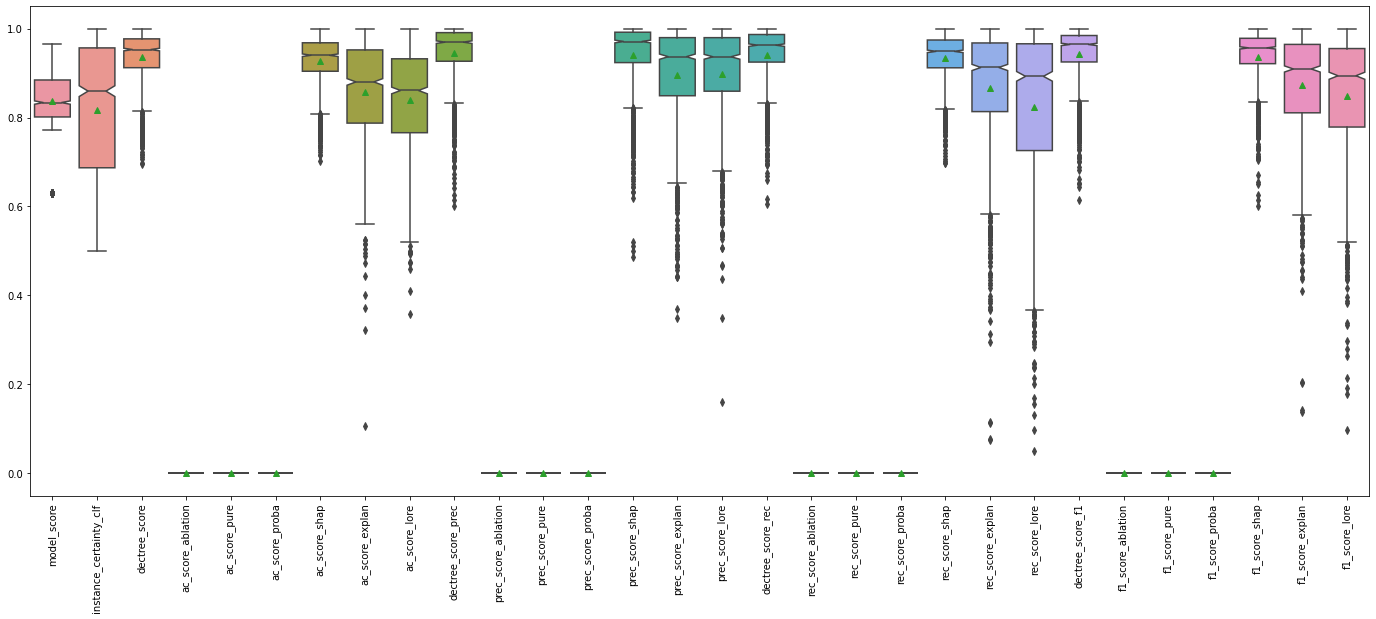

In [23]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid, notch=True,showmeans=True)
plt.xticks(rotation=90)

In [24]:
results_fid.groupby('dataset').mean().mean().sort_values()

f1_score_proba            0.000000
ac_score_ablation         0.000000
ac_score_pure             0.000000
ac_score_proba            0.000000
f1_score_pure             0.000000
f1_score_ablation         0.000000
prec_score_ablation       0.000000
prec_score_pure           0.000000
prec_score_proba          0.000000
rec_score_proba           0.000000
rec_score_pure            0.000000
rec_score_ablation        0.000000
instance_certainty_clf    0.816104
rec_score_lore            0.826081
model_score               0.836309
ac_score_lore             0.841125
f1_score_lore             0.849505
ac_score_explan           0.858040
rec_score_explan          0.868636
f1_score_explan           0.874458
prec_score_explan         0.894858
prec_score_lore           0.897547
ac_score_shap             0.930453
dectree_score             0.937094
rec_score_shap            0.937113
f1_score_shap             0.939479
dectree_score_rec         0.941896
prec_score_shap           0.943740
dectree_score_f1    

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'model_score'),
  Text(1, 0, 'instance_certainty_clf'),
  Text(2, 0, 'dectree_score'),
  Text(3, 0, 'ac_score_ablation'),
  Text(4, 0, 'ac_score_pure'),
  Text(5, 0, 'ac_score_proba'),
  Text(6, 0, 'ac_score_shap'),
  Text(7, 0, 'ac_score_explan'),
  Text(8, 0, 'ac_score_lore'),
  Text(9, 0, 'dectree_score_prec'),
  Text(10, 0, 'prec_score_ablation'),
  Text(11, 0, 'prec_score_pure'),
  Text(12, 0, 'prec_score_proba'),
  Text(13, 0, 'prec_score_shap'),
  Text(14, 0, 'prec_score_explan'),
  Text(15, 0, 'prec_score_lore'),
  Text(16, 0, 'dectree_score_rec'),
  Text(17, 0, 'rec_score_ablation'),
  Text(18, 0, 'rec_score_pure'),
  Text(19, 0, 'rec_score_proba'),
  Text(20, 0, 'rec_score_shap'),
  Text(21, 0, 'rec_score_explan'),
  Text(22, 0, 'rec_score_lore'),
  Text(23, 0, 'dectree_score_f1'),
  Text(24, 0, 'f1_score_ablation'),
  Text(25,

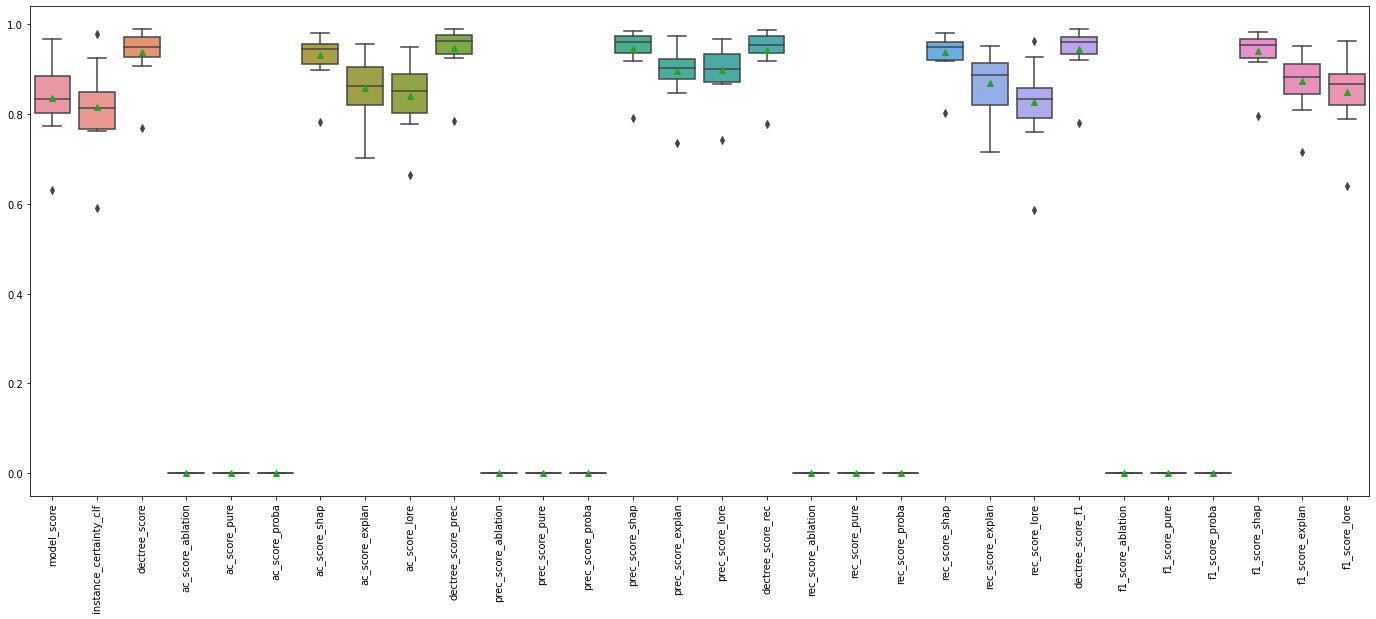

In [25]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid.groupby('dataset').mean(), notch=False,showmeans=True)
plt.xticks(rotation=90)

In [26]:
print('asd')

asd


In [27]:
results_imp_fid = pd.DataFrame(imp_fid_data,columns=['dataset','num_and_cat','importance_gain_dtree','importance_gain_ablation','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan','importance_gain_lore','importance_gain_anchor'])#.fillna(0)
#results_imp_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))    
results_imp_fid.to_csv(data_prefix+"synthx100_importance_gain.csv",index=False)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'importance_gain_dtree'),
  Text(1, 0, 'importance_gain_ablation'),
  Text(2, 0, 'importance_gain_noproba'),
  Text(3, 0, 'importance_gain_with_proba'),
  Text(4, 0, 'importance_gain_shap'),
  Text(5, 0, 'importance_gain_explan'),
  Text(6, 0, 'importance_gain_lore'),
  Text(7, 0, 'importance_gain_anchor')])

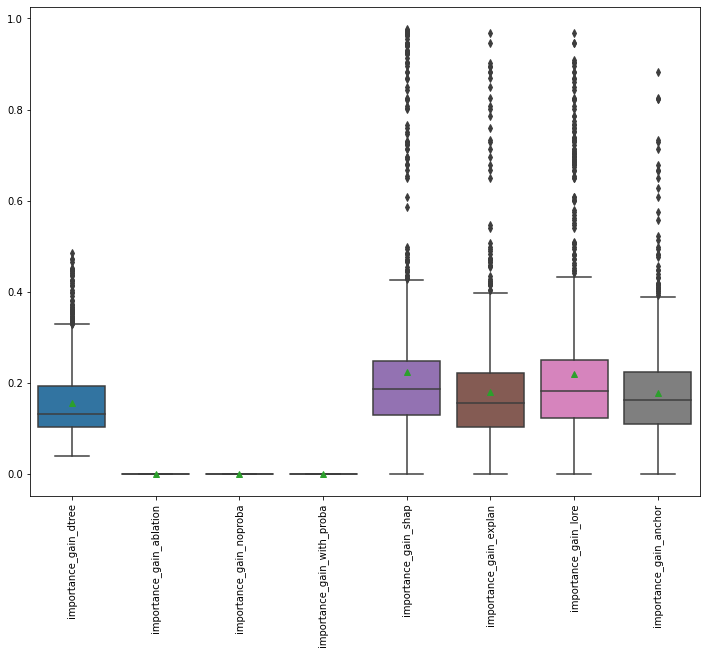

In [28]:
#one-shot
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=False,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [29]:
results_imp_fid.groupby('dataset').mean().mean().sort_values()

importance_gain_ablation      0.000000
importance_gain_noproba       0.000000
importance_gain_with_proba    0.000000
importance_gain_dtree         0.164408
importance_gain_anchor        0.189732
importance_gain_explan        0.197049
importance_gain_lore          0.241348
importance_gain_shap          0.241657
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'model_score'),
  Text(1, 0, 'instance_certainty_clf'),
  Text(2, 0, 'hits_dectree'),
  Text(3, 0, 'hits_lux_ablation'),
  Text(4, 0, 'hits_lux_pure'),
  Text(5, 0, 'hits_lux_proba'),
  Text(6, 0, 'hits_lux_shap'),
  Text(7, 0, 'hits_explan'),
  Text(8, 0, 'hits_lore'),
  Text(9, 0, 'hits_anchor')])

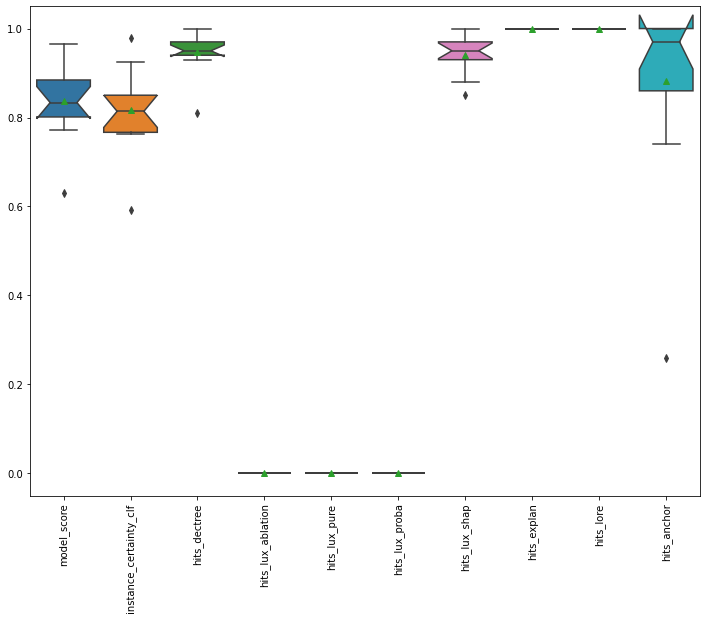

In [30]:
results_hits = pd.DataFrame(hits,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','hits_dectree','hits_lux_ablation','hits_lux_pure', 'hits_lux_proba', 'hits_lux_shap', 'hits_explan','hits_lore','hits_anchor'], dtype='f8')#.fillna(0)
results_hits.to_csv(data_prefix+"synthx100_hits.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_hits.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'time_lux_ablation'),
  Text(1, 0, 'time_lux_pure'),
  Text(2, 0, 'time_lux_proba'),
  Text(3, 0, 'time_lux_shap'),
  Text(4, 0, 'time_explan'),
  Text(5, 0, 'time_lore'),
  Text(6, 0, 'time_anchor')])

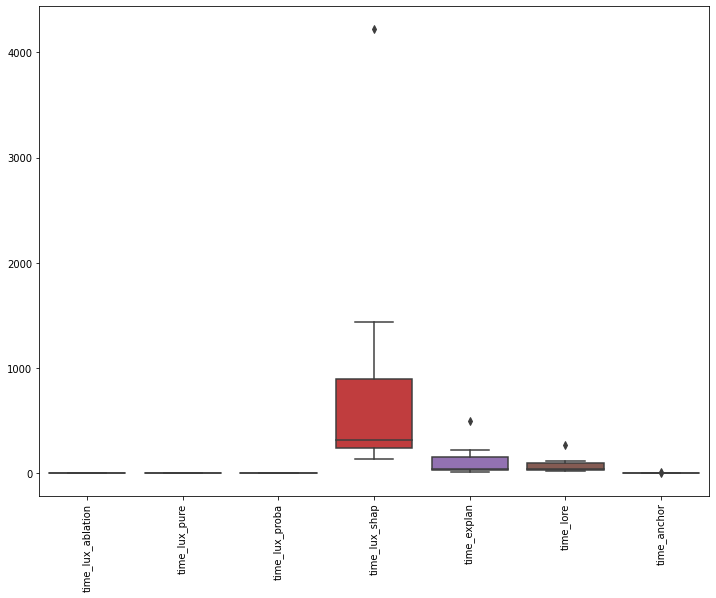

In [31]:
results_times = pd.DataFrame(times,columns=['dataset','num_and_cat','time_lux_ablation','time_lux_pure', 'time_lux_proba', 'time_lux_shap', 'time_explan', 'time_lore', 'time_anchor'], dtype='f8')#.fillna(0)
results_times.to_csv(data_prefix+"synthx100_times.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_times.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)



(array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

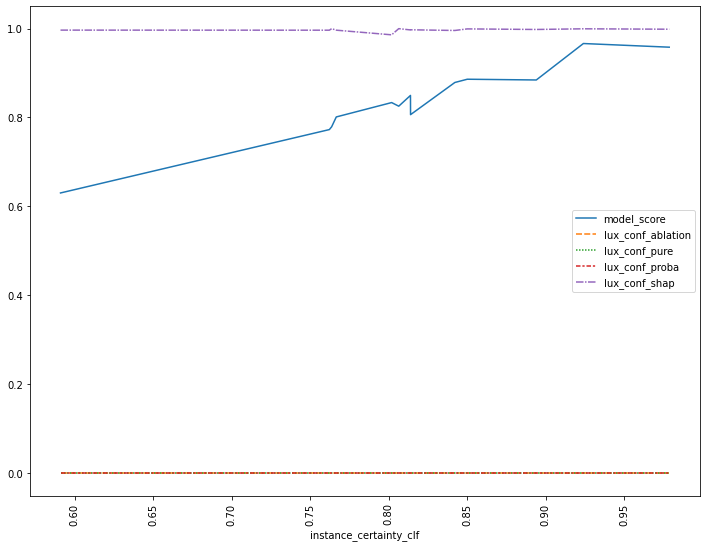

In [32]:
results_conf = pd.DataFrame(confidences,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','lux_conf_ablation','lux_conf_pure', 'lux_conf_proba', 'lux_conf_shap'], dtype='f8')#.fillna(0)
results_conf.to_csv(data_prefix+"synthx100_confidences.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.lineplot(data=results_conf.groupby('dataset').mean().set_index('instance_certainty_clf'),ax=ax)
plt.xticks(rotation=90)



(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'model_score'),
  Text(1, 0, 'instance_certainty_clf'),
  Text(2, 0, 'lux_conf_ablation'),
  Text(3, 0, 'lux_conf_pure'),
  Text(4, 0, 'lux_conf_proba'),
  Text(5, 0, 'lux_conf_shap')])

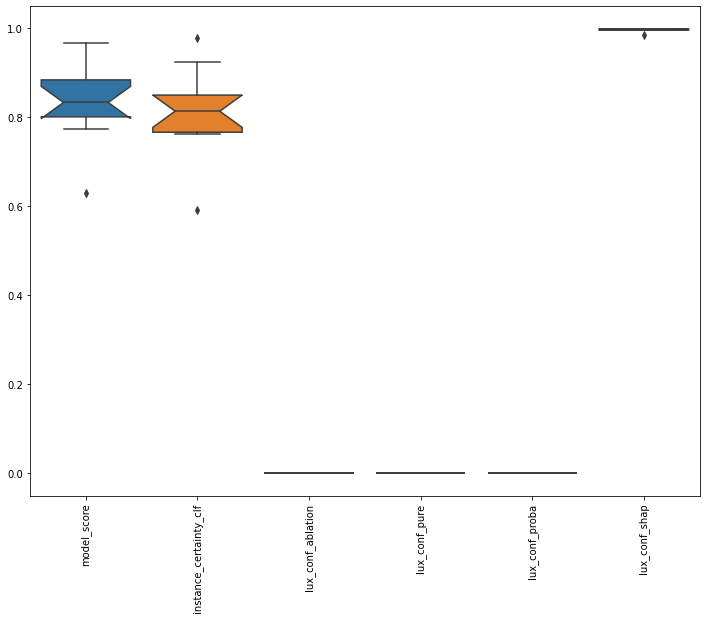

In [33]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_conf.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)


In [34]:
results_rules = pd.DataFrame(rules, columns=['dataset','num_and_cat','explain_instance','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor'])#.fillna(0)
results_rules.to_csv(data_prefix+"synthx100_rules.csv",index=False)

In [35]:
columns_fat =[['instance_mean_'+f, 'instance_std_'+f,'feature_mean_'+f, 'feature_std_'+f] for f in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']] 
columns= ['dataset','num_and_cat']+[item for sublist in columns_fat for item in sublist]
results_stab_data = pd.DataFrame(stability_data, columns=columns)
results_stab_data.to_csv(data_prefix+"synthx100_stability.csv",index=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, 'instance_mean_rule_lux_ablation'),
  Text(1, 0, 'instance_std_rule_lux_ablation'),
  Text(2, 0, 'feature_mean_rule_lux_ablation'),
  Text(3, 0, 'feature_std_rule_lux_ablation'),
  Text(4, 0, 'instance_mean_rule_lux_pure'),
  Text(5, 0, 'instance_std_rule_lux_pure'),
  Text(6, 0, 'feature_mean_rule_lux_pure'),
  Text(7, 0, 'feature_std_rule_lux_pure'),
  Text(8, 0, 'instance_mean_rule_lux_proba'),
  Text(9, 0, 'instance_std_rule_lux_proba'),
  Text(10, 0, 'feature_mean_rule_lux_proba'),
  Text(11, 0, 'feature_std_rule_lux_proba'),
  Text(12, 0, 'instance_mean_rule_lux_shap'),
  Text(13, 0, 'instance_std_rule_lux_shap'),
  Text(14, 0, 'feature_mean_rule_lux_shap'),
  Text(15, 0, 'feature_std_rule_lux_shap'),
  Text(16, 0, 'instance_mean_rule_EXPLAN'),
  Text(17, 0, 'instance_std_rule_EXPLAN'),
  Text(18, 0, 'feature_mean_rule_EXPLAN'),
  Text(19,

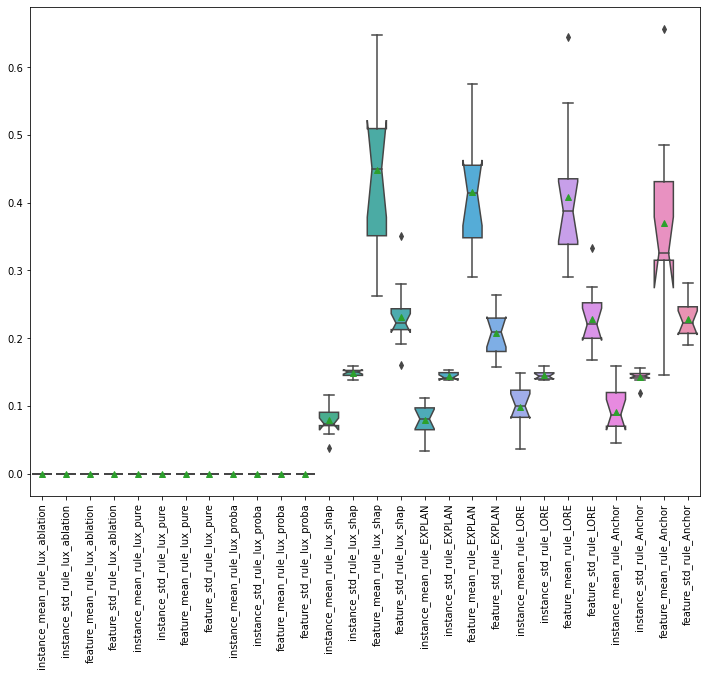

In [36]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_stab_data.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'instance_certainty_clf'),
  Text(1, 0, 'ac_score_ablation_acc'),
  Text(2, 0, 'ac_score_pure_acc'),
  Text(3, 0, 'ac_score_proba_acc'),
  Text(4, 0, 'ac_score_shap_acc'),
  Text(5, 0, 'model_score'),
  Text(6, 0, 'dectree_score_acc'),
  Text(7, 0, 'ac_score_explan_acc'),
  Text(8, 0, 'ac_score_lore_acc')])

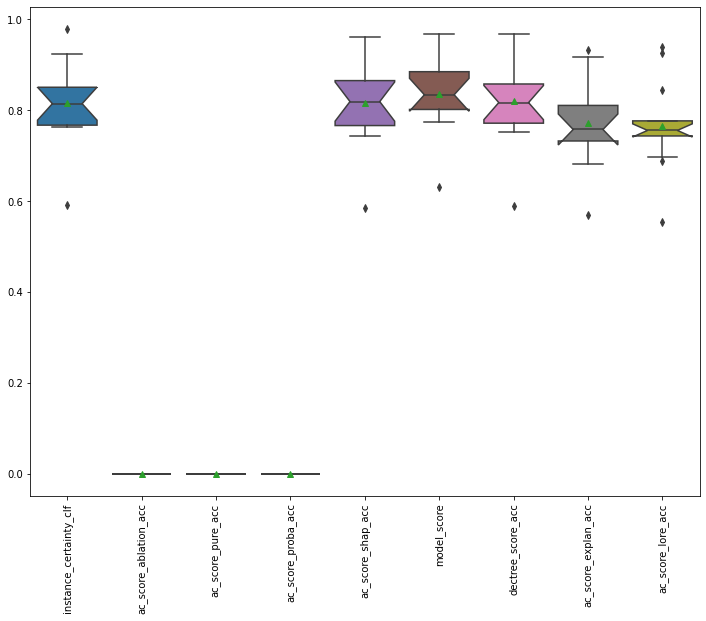

In [37]:
results_nac = pd.DataFrame(nac_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_ablation_acc','ac_score_pure_acc','ac_score_proba_acc','ac_score_shap_acc', 'model_score', 'dectree_score_acc','ac_score_explan_acc','ac_score_lore_acc'
                         ], dtype='f8')#.fillna(0)
results_nac.to_csv(data_prefix+"synthx100_nac.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_nac.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)


In [44]:
results_rulecov

dataset                     num_and_cat  model_score  \
0       data_house_16H  ./data/numerical_only/balanced     0.878707   
1       data_house_16H  ./data/numerical_only/balanced     0.878707   
2       data_house_16H  ./data/numerical_only/balanced     0.878707   
3       data_house_16H  ./data/numerical_only/balanced     0.878707   
4       data_house_16H  ./data/numerical_only/balanced     0.878707   
...                ...                             ...          ...   
1202  data_electricity  ./data/numerical_only/balanced     0.825450   
1203  data_electricity  ./data/numerical_only/balanced     0.825450   
1204  data_electricity  ./data/numerical_only/balanced     0.825450   
1205  data_electricity  ./data/numerical_only/balanced     0.825450   
1206  data_electricity  ./data/numerical_only/balanced     0.825450   

      instance_certainty_clf  cov_ablation  cov_pure  cov_proba  cov_shap  \
0                   0.951803           0.0       0.0        0.0  0.225979   
1                   0.986286           0.0       0.0        0.0  0.213227   
2                   0.944594           0.0       0.0        0.0  0.086299   
3                   0.964985           0.0       0.0        0.0  0.005931   
4                   0.949255           0.0       0.0        0.0  0.145314   
...                      ...           ...       ...        ...       ...   
1202                0.778950           0.0       0.0        0.0  0.019649   
1203                0.812024           0.0       0.0        0.0  0.059258   
1204                0.873242           0.0       0.0        0.0  0.335170   
1205                0.833299           0.0       0.0        0.0  0.120907   
1206                0.674825           0.0       0.0        0.0  0.269675   

      cov_EXPLAN  cov_LORE  cov_anchor  
0       0.137307  0.278766    0.000000  
1       0.222420  0.356168    0.056940  
2       0.024318  0.328292    0.037367  
3       0.239620  0.442171    0.037367  
4       0.031732  0.314947    0.059312  
...          ...       ...         ...  
1202    0.012995  0.254704    0.032540  
1203    0.066743  0.128808    0.107080  
1204    0.309076  0.354923    0.085248  
1205    0.326333  0.344215    0.235056  
1206    0.266972  0.074748    0.066119  

[1207 rows x 11 columns]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'model_score'),
  Text(1, 0, 'instance_certainty_clf'),
  Text(2, 0, 'cov_ablation'),
  Text(3, 0, 'cov_pure'),
  Text(4, 0, 'cov_proba'),
  Text(5, 0, 'cov_shap'),
  Text(6, 0, 'cov_EXPLAN'),
  Text(7, 0, 'cov_LORE'),
  Text(8, 0, 'cov_anchor')])

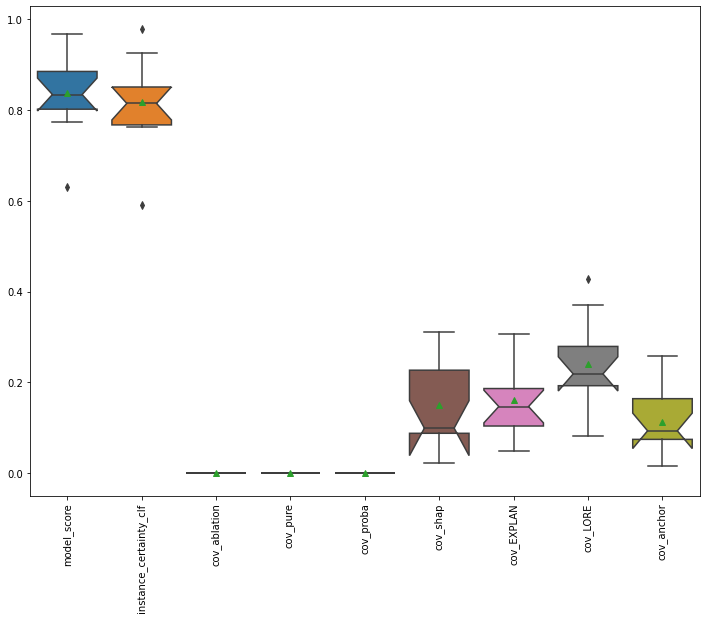

In [38]:
results_rulecov = pd.DataFrame(rule_coverages,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_rulecov.to_csv(data_prefix+"synthx100_rulecov.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_rulecov.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'model_score'),
  Text(1, 0, 'instance_certainty_clf'),
  Text(2, 0, 'cov_ablation'),
  Text(3, 0, 'cov_pure'),
  Text(4, 0, 'cov_proba'),
  Text(5, 0, 'cov_shap'),
  Text(6, 0, 'cov_EXPLAN'),
  Text(7, 0, 'cov_LORE'),
  Text(8, 0, 'cov_anchor')])

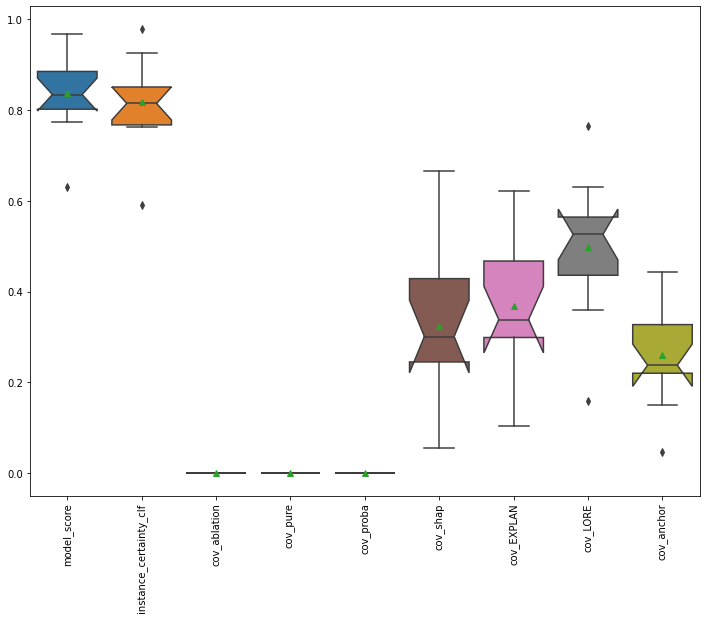

In [39]:
results_rulecov_nn = pd.DataFrame(rule_coverages_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_rulecov_nn.to_csv(data_prefix+"synthx100_rulecov_nn.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_rulecov_nn.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [40]:
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')
results_local_fid.isna().sum()/results_local_fid.shape[0]

dataset                   0.000000
num_and_cat               0.000000
model_score               0.000000
instance_certainty_clf    0.000000
acc_ablation              0.000000
acc_pure                  0.000000
acc_proba                 0.000000
acc_shap                  0.000000
acc_EXPLAN                0.000000
acc_LORE                  0.000000
acc_anchor                0.084507
prec_ablation             0.000000
prec_pure                 0.000000
prec_proba                0.000000
prec_shap                 0.000000
prec_EXPLAN               0.000000
prec_LORE                 0.000000
prec_anchor               0.000000
rec_ablation              0.000000
rec_pure                  0.000000
rec_proba                 0.000000
rec_shap                  0.000000
rec_EXPLAN                0.000000
rec_LORE                  0.000000
rec_anchor                0.000000
f1_ablation               0.000000
f1_pure                   0.000000
f1_proba                  0.000000
f1_shap             

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'model_score'),
  Text(1, 0, 'instance_certainty_clf'),
  Text(2, 0, 'acc_ablation'),
  Text(3, 0, 'acc_pure'),
  Text(4, 0, 'acc_proba'),
  Text(5, 0, 'acc_shap'),
  Text(6, 0, 'acc_EXPLAN'),
  Text(7, 0, 'acc_LORE'),
  Text(8, 0, 'acc_anchor'),
  Text(9, 0, 'prec_ablation'),
  Text(10, 0, 'prec_pure'),
  Text(11, 0, 'prec_proba'),
  Text(12, 0, 'prec_shap'),
  Text(13, 0, 'prec_EXPLAN'),
  Text(14, 0, 'prec_LORE'),
  Text(15, 0, 'prec_anchor'),
  Text(16, 0, 'rec_ablation'),
  Text(17, 0, 'rec_pure'),
  Text(18, 0, 'rec_proba'),
  Text(19, 0, 'rec_shap'),
  Text(20, 0, 'rec_EXPLAN'),
  Text(21, 0, 'rec_LORE'),
  Text(22, 0, 'rec_anchor'),
  Text(23, 0, 'f1_ablation'),
  Text(24, 0, 'f1_pure'),
  Text(25, 0, 'f1_proba'),
  Text(26, 0, 'f1_shap'),
  Text(27, 0, 'f1_EXPLAN'),
  Text(28, 0, 'f1_LORE'),
  Text(29, 0, 'f1_anchor')])

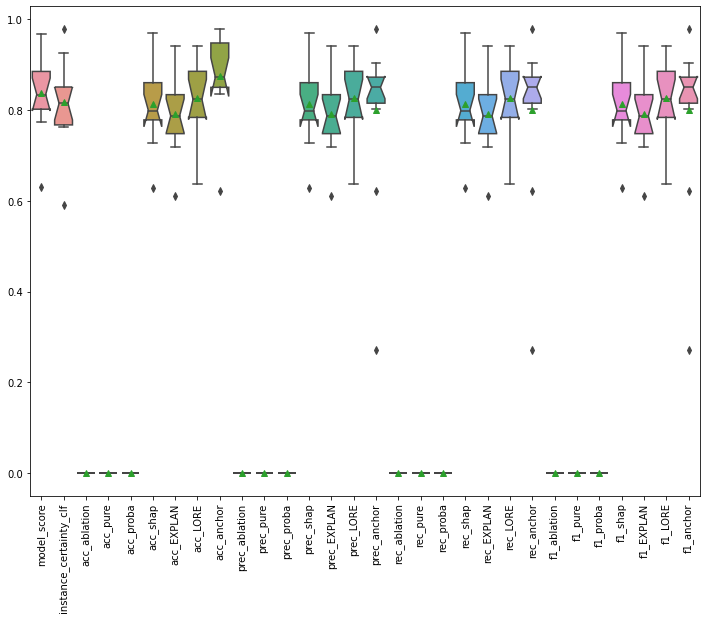

In [41]:
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
results_local_fid.to_csv(data_prefix+"synthx100_local_fid.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_local_fid.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'model_score'),
  Text(1, 0, 'instance_certainty_clf'),
  Text(2, 0, 'acc_ablation'),
  Text(3, 0, 'acc_pure'),
  Text(4, 0, 'acc_proba'),
  Text(5, 0, 'acc_shap'),
  Text(6, 0, 'acc_EXPLAN'),
  Text(7, 0, 'acc_LORE'),
  Text(8, 0, 'acc_anchor'),
  Text(9, 0, 'prec_ablation'),
  Text(10, 0, 'prec_pure'),
  Text(11, 0, 'prec_proba'),
  Text(12, 0, 'prec_shap'),
  Text(13, 0, 'prec_EXPLAN'),
  Text(14, 0, 'prec_LORE'),
  Text(15, 0, 'prec_anchor'),
  Text(16, 0, 'rec_ablation'),
  Text(17, 0, 'rec_pure'),
  Text(18, 0, 'rec_proba'),
  Text(19, 0, 'rec_shap'),
  Text(20, 0, 'rec_EXPLAN'),
  Text(21, 0, 'rec_LORE'),
  Text(22, 0, 'rec_anchor'),
  Text(23, 0, 'f1_ablation'),
  Text(24, 0, 'f1_pure'),
  Text(25, 0, 'f1_proba'),
  Text(26, 0, 'f1_shap'),
  Text(27, 0, 'f1_EXPLAN'),
  Text(28, 0, 'f1_LORE'),
  Text(29, 0, 'f1_anchor')])

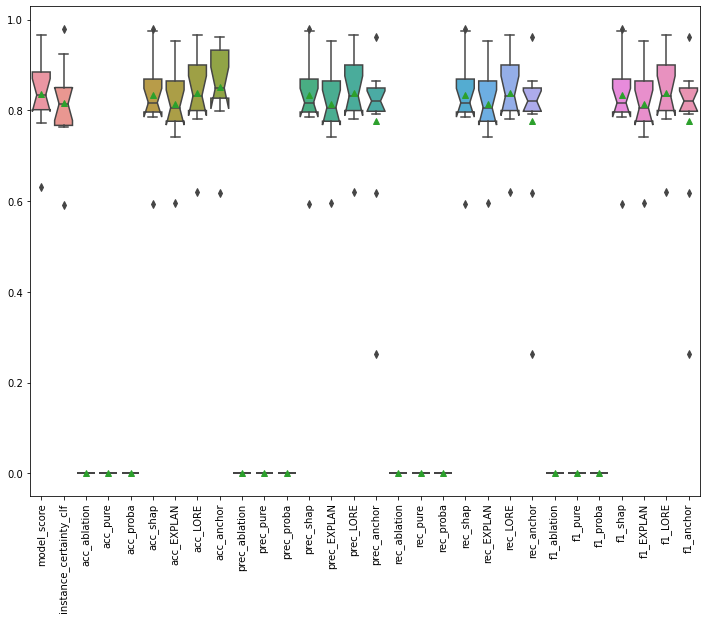

In [42]:
results_local_fid_nn = pd.DataFrame(rule_local_fid_data_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
results_local_fid_nn.to_csv(data_prefix+"synthx100_local_fid_nn.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_local_fid_nn.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'model_score'),
  Text(1, 0, 'instance_certainty_clf'),
  Text(2, 0, 'dtree_elen'),
  Text(3, 0, 'ablation_lux_elen'),
  Text(4, 0, 'pure_lux_elen'),
  Text(5, 0, 'proba_lux_elen'),
  Text(6, 0, 'shap_lux_elen'),
  Text(7, 0, 'explan_elen'),
  Text(8, 0, 'lore_elen'),
  Text(9, 0, 'anchor_elen')])

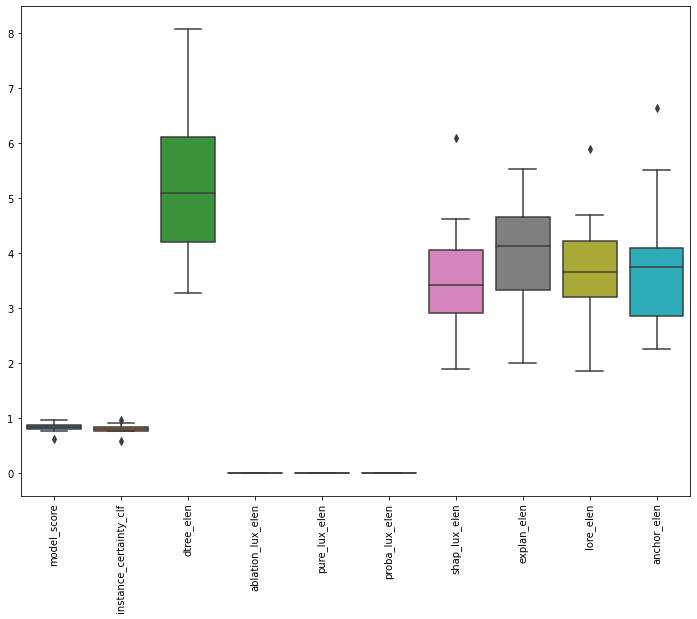

In [43]:
exp_elen = pd.DataFrame(explanation_length,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                            'dtree_elen', 'ablation_lux_elen','pure_lux_elen', 'proba_lux_elen', 
                                                            'shap_lux_elen', 'explan_elen', 'lore_elen', 'anchor_elen'], dtype='f8')#.dropna()#fillna(0)
exp_elen.to_csv(data_prefix+"synthx100_rulelen.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=exp_elen.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)